## Load data

In [1]:
import numpy as np
import pandas as pd

In [2]:
import os
import platform
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import time
import math

In [3]:
print("python version:\t\t", platform.python_version())
print("networkx version:\t", nx.__version__)

python version:		 3.8.3
networkx version:	 2.4


In [4]:
def load_pickle(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)     
G2 = load_pickle('Subgraph1.pkl')
print(nx.info(G2))

Name: 
Type: MultiDiGraph
Number of nodes: 9595165
Number of edges: 39319247
Average in degree:   4.0978
Average out degree:   4.0978


In [5]:
# Travelsal edges:
for ind, edge in enumerate(nx.edges(G2)):
    # gets the nodes on both sides of the edge.
    (u, v) = edge
    # gets the first edge from node u to node v.
    eg = G2[u][v][0]
    # gets the properties of the directed edge: the amount and timestamp of the transaction.
    amo, tim = eg['amount'], eg['timestamp']
    print("amount:", amo)
    print("timestamp:", tim)
    break

amount: 4.999
timestamp: 1506787211


## Statistics

In [6]:
def shift_time(timeStamp):
    timeArray=time.localtime(timeStamp)
    otherStyleTime=time.strftime("%Y--%m--%d %H:%M:%S",timeArray)
#     year=timeArray.tm_year
#     month=timeArray.tm_mon
#     day=timeArray.tm_mday
    return otherStyleTime

In [7]:
phishing_set=set(pd.read_csv('addresses/Phish.csv')['Phish'].values.tolist())

In [8]:
all_ndset=set([nd for idx,nd in enumerate(G2.nodes)])
phishing_set=phishing_set&all_ndset
print(len(phishing_set))

214


In [9]:
phish_in_neighs=[len(G2.pred[nd]) for nd in phishing_set]
phish_out_neighs=[len(G2.succ[nd]) for nd in phishing_set]
phish_acum_ratio=[len(G2.pred[nd])/(len(G2.pred[nd])+len(G2.succ[nd])) for nd in phishing_set]

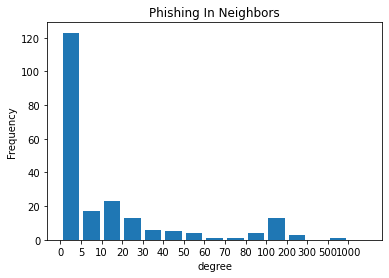

In [10]:
#plt indegree
bins=[0,5,10,20,30,40,50,60,70,80,100,200,300,500,1000,10000]
hist,bin_edges = np.histogram(phish_in_neighs,bins) # make the histogram
plt.title('Phishing In Neighbors')
plt.ylabel('Frequency')
plt.xlabel('degree')

# # Plot the histogram heights against integers on the x axis
plt.bar(range(len(hist)),hist,width=0.8) 

# # Set the ticks to the middle of the bars
plt.xticks([i-0.5 for i,j in enumerate(hist)],['{}'.format(bins[i]) for i,j in enumerate(hist)])
                                                           
plt.show()
# plt.hist(phish_indegree,bins)

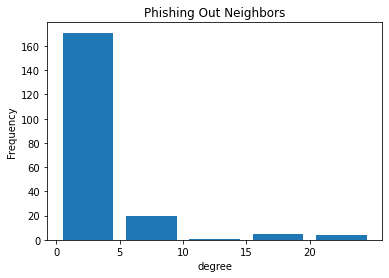

In [11]:
#plt outdegree
bins=list(range(0,30,5))
hist,bin_edges = np.histogram(phish_out_neighs,bins) # make the histogram
plt.title('Phishing Out Neighbors')
plt.ylabel('Frequency')
plt.xlabel('degree')

# # Plot the histogram heights against integers on the x axis
plt.bar(range(len(hist)),hist,width=0.8) 

# # Set the ticks to the middle of the bars
plt.xticks([i-0.5 for i,j in enumerate(hist)],['{}'.format(bins[i]) for i,j in enumerate(hist)])
                                                           
plt.show()
# plt.hist(phish_indegree,bins)

(array([30.,  2., 10.,  4.,  8., 34., 18., 14., 29., 65.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

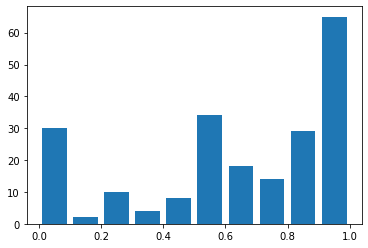

In [12]:
plt.hist(phish_acum_ratio,10,(0,1),rwidth=0.8)

In [13]:
np.mean(phish_acum_ratio)

0.6300538098544172

## Service Address Classification

In [14]:
exchange_set=set(pd.read_csv('addresses/Exchange.csv')['Exchange'].values.tolist())

In [15]:
dex_set=set(pd.read_csv('addresses/DEX.csv')['DEX'].values.tolist())

In [16]:
exchange_set=exchange_set&all_ndset
dex_set=dex_set&all_ndset
print(len(exchange_set),len(dex_set))

106 27


In [17]:
all_exchanges=exchange_set|dex_set
print(len(all_exchanges))

133


In [18]:
token_set=set(pd.read_csv('addresses/Token.csv')['Token'].values.tolist())

In [19]:
token_set=token_set&all_ndset
print(len(token_set))

58


In [20]:
phishing_token=token_set&phishing_set
print(len(phishing_token))
token_set=token_set-phishing_token
print(len(token_set))

0
58


In [21]:
contract_set=set(pd.read_csv('addresses/Contract.csv')['Smart Contract'].values.tolist())&all_ndset
print(len(contract_set))

462898


In [22]:
print(contract_set&phishing_set)

{'0x1abc65765fd0df7d997635ebe3027384bcf7923e', '0x902d0d5bb6a34307bbd1da33e61ae1654b6cbe1e', '0x0a4a2413d7c604647c7788fd3564b3c54fe06763', '0x02fd82cba3bae39484d5eb7f75b5f3d5f418c691', '0x34959919244b18128d084834dba11f0c91732ede', '0x8ba9512714fd69be49883e755cfb82ec46c6bd11'}


In [23]:
inactive_set=set(pd.read_csv('addresses/EOA_inactive.csv')['EOA/inactive'].values.tolist())&all_ndset
print(len(inactive_set))

774167


In [24]:
print(len(inactive_set&phishing_set))

4


In [25]:
hack_set=set(pd.read_csv('addresses/Hack.csv')['Hack'].values.tolist())
hack_set=hack_set&all_ndset
print(len(hack_set))

4


In [26]:
def set_bool_label(labelname,label_set):
    for idx,nd in enumerate(G2.nodes):
        G2.nodes[nd][labelname]=0
    for nd in label_set:
        G2.nodes[nd][labelname]=1

In [27]:
set_bool_label('isp',phishing_set)
set_bool_label('ish',hack_set)

In [28]:
set_bool_label('iss',all_exchanges)
set_bool_label('ist',token_set)

In [29]:
set_bool_label('isc',contract_set)
set_bool_label('is_inact',inactive_set)

## Degree  distribution

In [30]:
n=len(G2.nodes)
in_degrees=dict()
out_degrees=dict()

#compute in-degree and out-degree of all nodes

#in-degree
for idx,indegree in enumerate(G2.in_degree()):
    (nd,idg)=indegree
    in_degrees[nd]=idg
in_values=sorted(set(in_degrees.values()))
in_hist=[list(in_degrees.values()).count(x) for x in in_values]
print(len(in_values),len(in_hist))
in_distrb=[x/n for x in in_hist]

#out-degree
for idx,outdegree in enumerate(G2.out_degree()):
    (nd,odg)=outdegree
    out_degrees[nd]=odg
out_values=sorted(set(out_degrees.values()))
out_hist=[list(out_degrees.values()).count(x) for x in out_values]
out_distrb=[x/n for x in out_hist]
print(len(out_values),len(out_hist))

1545 1545
1414 1414


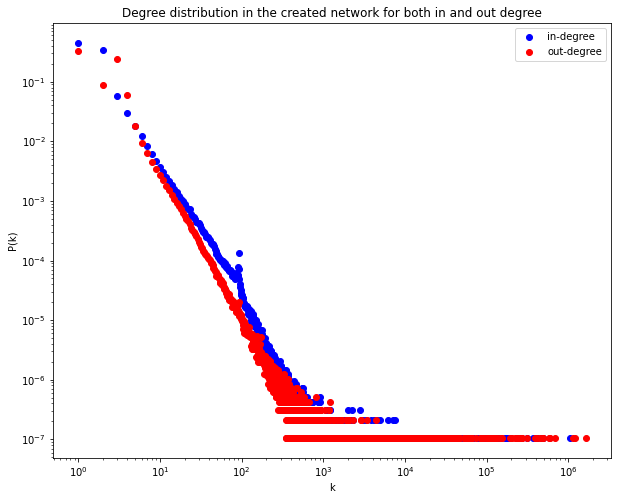

In [31]:
#plot the degree distribution
xlabel="k"
ylabel="P(k)"
title="Degree distribution in the created network for both in and out degree"
figsize=(10,8)
plt.figure(figsize=figsize)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)
plt.loglog(in_values,in_distrb,'o',color='blue',label='in-degree')
plt.loglog(out_values,out_distrb,'o',color='red',label='out-degree')
plt.legend(loc='upper right')
plt.show()

In [32]:
#top addresses with the higheset node degree
L_in=sorted(in_degrees.items(),key=lambda x:x[1],reverse=True)
print(L_in[:5])
L_out=sorted(out_degrees.items(),key=lambda x:x[1],reverse=True)
print(L_out[:5])

[('0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98', 1046095), ('0x8d12a197cb00d4747a1fe03395095ce2a5cc6819', 487551), ('0x06012c8cf97bead5deae237070f9587f8e7a266d', 479680), ('0x70faa28a6b8d6829a4b1e649d26ec9a2a39ba413', 473848), ('0x32be343b94f860124dc4fee278fdcbd38c102d88', 407746)]
[('0xea674fdde714fd979de3edf0f56aa9716b898ec8', 1622508), ('0x829bd824b016326a401d083b33d092293333a830', 1212553), ('0x52bc44d5378309ee2abf1539bf71de1b7d7be3b5', 1128534), ('0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98', 691109), ('0x5a0b54d5dc17e0aadc383d2db43b0a0d3e029c4c', 591208)]


In [121]:
N_in=sorted([len(G2.pred[nd]) for idx,nd in enumerate(G2.nodes)])
N_out=sorted([len(G2.succ[nd]) for idx,nd in enumerate(G2.nodes)])

In [131]:
print(N_in[int(len(G2)*0.999):int(len(G2)*0.999)+5])
print(N_out[int(len(G2)*0.999):int(len(G2)*0.999)+5])

[29, 29, 29, 29, 29]
[38, 38, 38, 38, 38]


##  Detect Phishing Gang (with taint analysis)

In [33]:
#link weight and node value method
#compute sum of in-links and out-links
for idx,nd in enumerate(G2.nodes):
    G2.nodes[nd]['out_values']=0
    for ond,label in G2.adj[nd].items():
        amounts=[x['amount'] for x in label.values()]#sum of transaction amount of two nodes 
        G2.nodes[nd]['out_values']+=sum(amounts)
    G2.nodes[nd]['in_values']=0
    for ind,label in G2.pred[nd].items():
        amounts=[x['amount'] for x in label.values()]
        G2.nodes[nd]['in_values']+=sum(amounts)
print(G2.nodes[nd]['in_values'],G2.nodes[nd]['out_values'])

0.159006 0


In [34]:
#initial label of nodes
def initial_taint(original_nodes):
    for idx,nd in enumerate(G2.nodes):
        if nd in original_nodes:
            G2.nodes[nd]['taint']=1
            G2.nodes[nd]['visited']=True
        else:
            G2.nodes[nd]['taint']=0
            G2.nodes[nd]['visited']=False
        
#link weight and node value equation            
def taint_compute1(node):
    taint_sum=0
    for ind,label in G2.pred[node].items():
        amounts=[int(x['amount']) for x in label.values()]
        taint_sum+=G2.nodes[ind]['taint']*sum(amounts)
    return taint_sum/G2.nodes[node]['in_values'] if G2.nodes[node]['in_values']>0 else 0
        
#BFS spread
def taint_spread1(original_nodes):
    #initial
    initial_taint(original_nodes)
    #spread
    queue=original_nodes.copy()
    while len(queue)>0:
        pre_nd=queue.pop(0)
        for nd in G2.adj[pre_nd]:
            if not G2.nodes[nd]['visited'] and G2.nodes[nd]['iss']!=1 and G2.nodes[nd]['ist']!=1:
                G2.nodes[nd]['visited']=True
                queue.append(nd)
                G2.nodes[nd]['taint']=taint_compute1(nd)

In [35]:
taint_spread1(list(phishing_set))
in_tainted_values1=[G2.nodes[nd]['taint'] for idx,nd in enumerate(G2.nodes)]
in_tainted_values1=sorted(in_tainted_values1,reverse=True)

In [37]:
#link weight and node value equation            
def taint_compute(node,days):
    weight_list=[]
    for ind,label in G2.pred[node].items():
        weight_list.extend([(x['timestamp'],x['amount'],ind) for x in label.values()])
    weight_list=sorted(weight_list,key=lambda x:x[0])
    time_step=days*24*60*60
    time_begin=weight_list[0][0]
    time_end=weight_list[-1][0]
    taint_values=[]
    taint_sum=0
    money_sum=0
    for tim,val,ind in weight_list:
        if time_begin+time_step>tim:
            taint_sum+=G2.nodes[ind]['taint']*val
            money_sum+=val
        else:
            break
    taint_values.append(taint_sum/money_sum if money_sum>0 else 0)
    for i in range(1,len(weight_list)):
        time_begin=weight_list[i][0]
        if time_begin+time_step<time_end:
            break
        else:
            for j in range(i,len(weight_list)):
                tim,val,ind=weight_list[j]
                if time_begin+time_step>tim:
                    taint_sum+=G2.nodes[ind]['taint']*val
                    money_sum+=val
                else:
                    break
            taint_values.append(taint_sum/money_sum if money_sum>0 else 0)
    return max(taint_values)   

#BFS spread
def taint_spread_iter(original_nodes):
    #spread
    queue=original_nodes.copy()
    while len(queue)>0:
        pre_nd=queue.pop(0)
        for nd in G2.adj[pre_nd]:
            if not G2.nodes[nd]['visited'] and G2.nodes[nd]['iss']!=1 and G2.nodes[nd]['ist']!=1:
                G2.nodes[nd]['visited']=True
                queue.append(nd)
                G2.nodes[nd]['taint']=taint_compute(nd,15)

def taint_spread(original_nodes,iter_num):
    initial_taint(original_nodes)
    for i in range(iter_num):
        taint_spread_iter(original_nodes)

In [38]:
#Get the values of link wight ratio TaintRank
taint_spread(list(phishing_set),1)

In [39]:
in_tainted_values=[G2.nodes[nd]['taint'] for idx,nd in enumerate(G2.nodes)]
in_tainted_values=sorted(in_tainted_values,reverse=True)

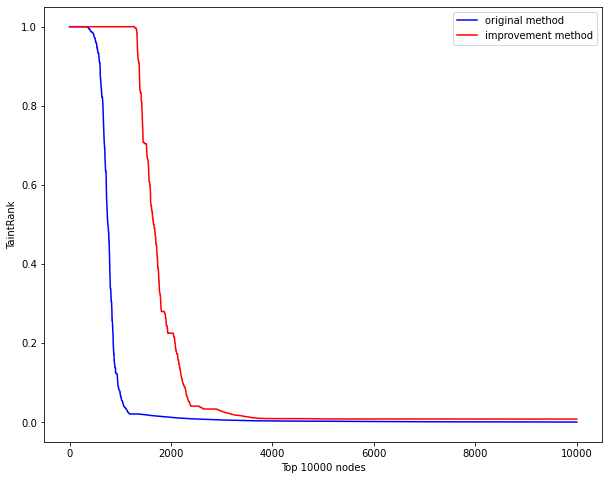

In [40]:
#plot
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 15,
}
xlabel="Top 10000 nodes"
ylabel="TaintRank"
title="Jul~Sep.2020"
figsize=(10,8)
plt.figure(figsize=figsize)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
# plt.title(title,font1)
plt.plot(range(10000),in_tainted_values1[:10000],color='blue',label='original method')
plt.plot(range(10000),in_tainted_values[:10000],color='red',label='improvement method')
plt.legend(loc='upper right')
plt.show()

In [41]:
print(len([val for val in in_tainted_values if val>0]))

4857730


In [42]:
def is_accumulation(nd):
    inn=len(G2.pred[nd])
    outn=len(G2.succ[nd])
    ratio=inn/(inn+outn) if (inn+outn)>0 else 0
    ins=G2.in_degree[nd]
    outs=G2.out_degree[nd]
    iratio=ins/inn if inn>0 else 0
    oratio=outs/outn if outn>0 else 0
    in_values=G2.nodes[nd]['in_values']
    out_values=G2.nodes[nd]['out_values']
    if ratio>=0.7 and inn>10 and inn<230 and outn>0 and outn<66 and iratio<=2 and oratio<=4 and in_values>0 and out_values>0:
        return True
    return False

def is_bridge(nd):
    inn=len(G2.pred[nd])
    outn=len(G2.succ[nd])
    taint=G2.nodes[nd]['taint']
    if inn<=3 and outn<=3 and taint>=0.1:
        return True
    if taint>=0.5:
        return True
    return False

def is_token(nd):
    if G2.nodes[nd]['ist']==1:
        return True
    return False

def is_exchange(nd):
    if G2.nodes[nd]['iss']==1:
        return True
    return False

def is_phish(nd):
    if G2.nodes[nd]['isp']==1:
        return True
    return False

def is_hack(nd):
    if G2.nodes[nd]['ish']==1:
        return True
    return False

for idx,nd in enumerate(G2.nodes):
    if len(G2.pred[nd])+len(G2.succ[nd])>=100:
        G2.nodes[nd]['label']='HC'
    else:
        G2.nodes[nd]['label']='LC'
    if is_accumulation(nd):
        G2.nodes[nd]['label']='A'
    if is_bridge(nd):
        G2.nodes[nd]['label']='B'
    if is_token(nd):
        G2.nodes[nd]['label']='T'
    if is_exchange(nd):
        G2.nodes[nd]['label']='E'
    if is_hack(nd):
        G2.nodes[nd]['label']='H'
    if is_phish(nd):
        G2.nodes[nd]['label']='P'

In [43]:
accum_address=[nd for idx,nd in enumerate(G2.nodes) if is_accumulation(nd)]
accum_phish=[nd for nd in phishing_set if is_accumulation(nd)]
print(len(phishing_set)/len(G2),len(accum_phish)/len(accum_address),len(accum_address),len(accum_phish))

2.2302899429035354e-05 0.0013786894009735235 35541 49


In [44]:
def initial_visit(original_nd):
    G2.nodes[original_nd]['visited']=True
    for idx,nd in enumerate(G2.nodes):
        if nd!=original_nd:
            G2.nodes[nd]['visited']=False
            
def detection_phishing_gang2(phishing_nd):
    initial_visit(phishing_nd)
    phishing_gang=set()
    mates=set()
    acc_set=set()
    mates.add(phishing_nd)
    while len(mates)!=0:
        b=mates.pop()
        G2.nodes[b]['visited']=True
        bri_set=set()
        psh_set=set()
        hac_set=set()
        for nd in G2.pred[b]:
            if not G2.nodes[nd]['visited']:
                if G2.nodes[nd]['label']=='A':
                    acc_set.add(nd)
                if G2.nodes[nd]['label']=='B':
                    bri_set.add(nd)
                if G2.nodes[nd]['label']=='P':
                    psh_set.add(nd)
                if G2.nodes[nd]['label']=='H':
                    hac_set.add(nd)
        for nd in G2.succ[b]:
            if not G2.nodes[nd]['visited']:
                if G2.nodes[nd]['label']=='A':
                    acc_set.add(nd)
                if G2.nodes[nd]['label']=='B':
                    bri_set.add(nd)
                if G2.nodes[nd]['label']=='P':
                    psh_set.add(nd)
                if G2.nodes[nd]['label']=='H':
                    hac_set.add(nd)
        phishing_gang.add(b)
        mates=mates|bri_set|psh_set|hac_set
    #select suspect phishing    
    for nd in acc_set:
        in_gang_values=0
        out_gang_values=0
        for pnd,label in G2.pred[nd].items():
            if pnd in phishing_gang:
                in_gang_values+=sum([x['amount'] for x in label.values()])
        for snd,label in G2.succ[nd].items():
            if snd in phishing_gang:
                out_gang_values+=sum([x['amount'] for x in label.values()])
        if out_gang_values/G2.nodes[nd]['out_values']>=0.1 or in_gang_values/G2.nodes[nd]['in_values']>=0.1:
            phishing_gang.add(nd)
    return phishing_gang.copy()

In [45]:
phishing_gang_sets2=[]
for ond in phishing_set:
    phishing_gang=detection_phishing_gang2(ond)
    phishing_gang_sets2.append(phishing_gang)
    print(len(phishing_gang),end=' ')

5 178 56 18 178 1 1 10 13 1 2 3 4 77 1 334 217 9 5 2 217 4 334 13 2 1 2 2 1 178 1 178 1 3 1 1 3 23 13 4 6 15 5 10 3 1 12 178 14 25 4 22 8 1 5 1 77 1 1 1 4 5 2 1 1 3 2 3 16 2 10 2 7 2 111 13 18 1 24 23 2 178 5 5 9 1 217 2 14 2 3 88 2 1 2 3 4 2 4 5 178 20 178 2 1 2 8 2 1 77 21 3 8 13 217 1 2 3 2 2 1 1 5 217 2 3 45 1 7 1 2 178 2 1 5 1 1 4 334 2 1 2 17 21 18 2 1 16 3 1 1 13 1 178 3 5 2 1 334 2 1 1 2 2 1 2 9 6 2 3 1 5 217 334 334 3 11 15 8 6 4 4 23 1 1 2 2 2 334 334 4 5 1 2 2 334 6 2 334 14 2 1 1 22 1 1 1 1 178 11 1 9 334 2 

In [46]:
remove_ids=[]
for i in range(len(phishing_gang_sets2)):
    if i in remove_ids:
        continue
    for j in range(i+1,len(phishing_gang_sets2)):
        if phishing_gang_sets2[i]==phishing_gang_sets2[j]:
            remove_ids.append(j)
            
phishing_gang_sets3=[]
for i in range(len(phishing_gang_sets2)): 
    if i not in remove_ids:
        phishing_gang_sets3.append(phishing_gang_sets2[i])
print(len(phishing_gang_sets3))

176


In [47]:
def draw_gang_graph(phishing_gang):
    print('Phishing Gang',"Num="+str(len(phishing_gang)))
    accums=[]
    hacks=[]
    phishs=[]
    inactives=[]
    for nd in phishing_gang:
#         print(nd,in_degrees[nd],out_degrees[nd],G2.nodes[nd]['isp'])
        if G2.nodes[nd]['label']=='A':
            accums.append(nd)
        if G2.nodes[nd]['label']=='H':
            hacks.append(nd)
        if G2.nodes[nd]['label']=='P':
            phishs.append(nd)
        if G2.nodes[nd]['is_inact']==1:
            inactives.append(nd)
    sub_graph=G2.subgraph(phishing_gang)
    plt.figure(figsize=(8,8))
    pos=nx.kamada_kawai_layout(sub_graph,scale=8)
    nx.draw_networkx_nodes(sub_graph,pos,node_size=100,alpha=0.7)
    nx.draw_networkx_edges(sub_graph,pos,node_size=100,alpha=0.3)
    nx.draw_networkx_nodes(sub_graph,pos,nodelist=inactives,node_color='blue',node_size=100,alpha=0.7)
    nx.draw_networkx_nodes(sub_graph,pos,nodelist=hacks,node_color='black',node_size=100,alpha=1)
    nx.draw_networkx_nodes(sub_graph,pos,nodelist=accums,node_color='darkorange',node_size=100,alpha=1)
    nx.draw_networkx_nodes(sub_graph,pos,nodelist=phishs,node_color='red',node_size=100,alpha=1)
    plt.show()

Phishing Gang Num=5


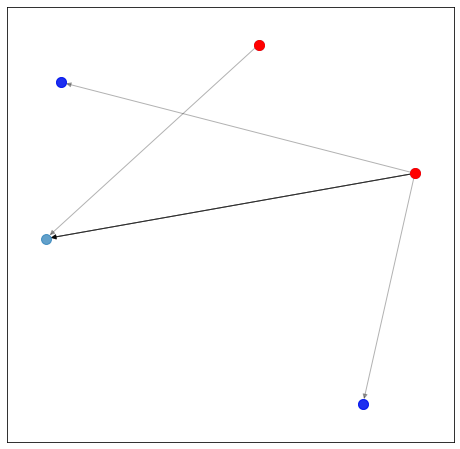

Phishing Gang Num=178


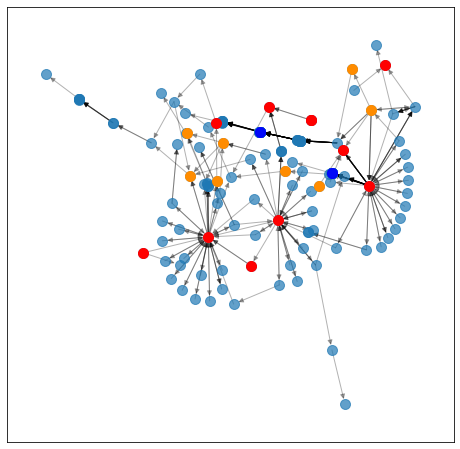

Phishing Gang Num=56


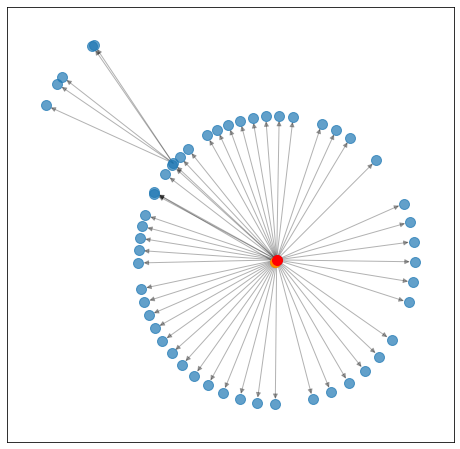

Phishing Gang Num=18


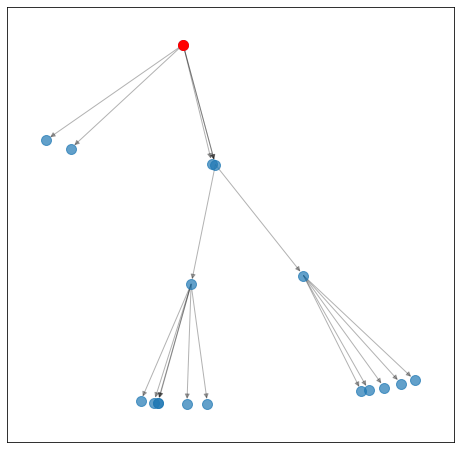

Phishing Gang Num=10


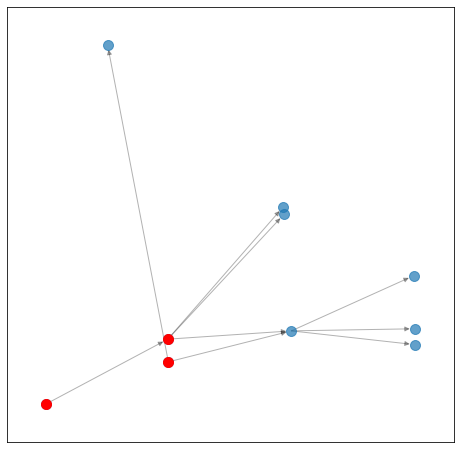

Phishing Gang Num=13


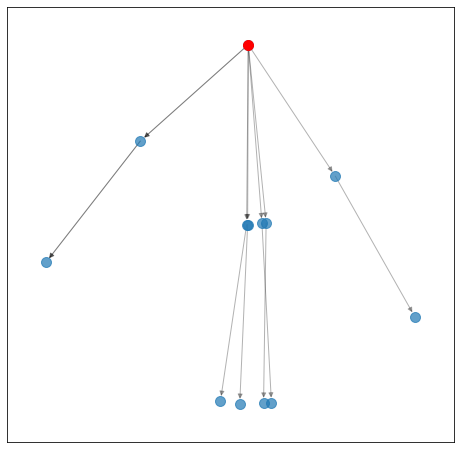

Phishing Gang Num=2


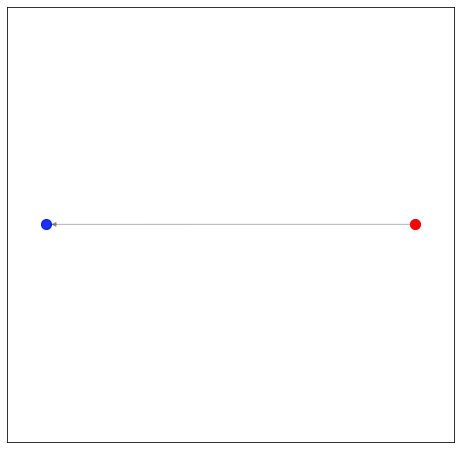

Phishing Gang Num=3


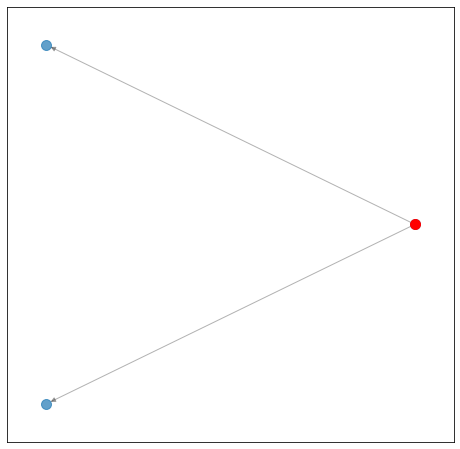

Phishing Gang Num=4


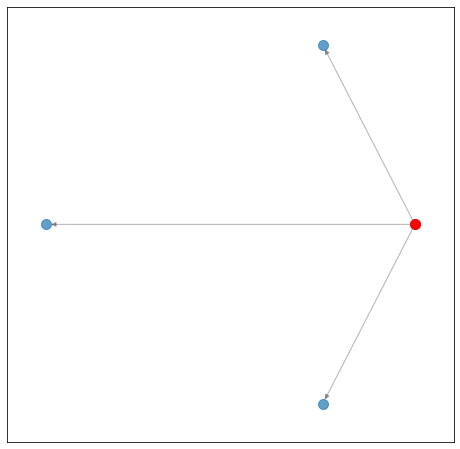

Phishing Gang Num=77


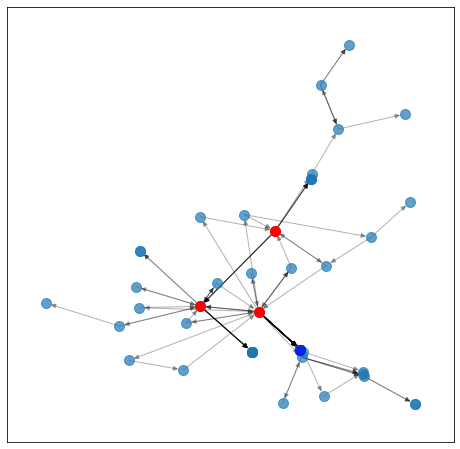

Phishing Gang Num=334


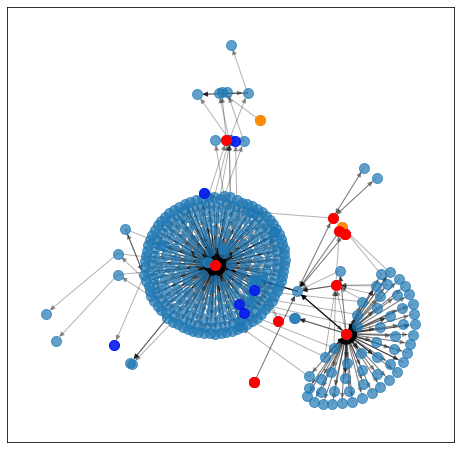

Phishing Gang Num=217


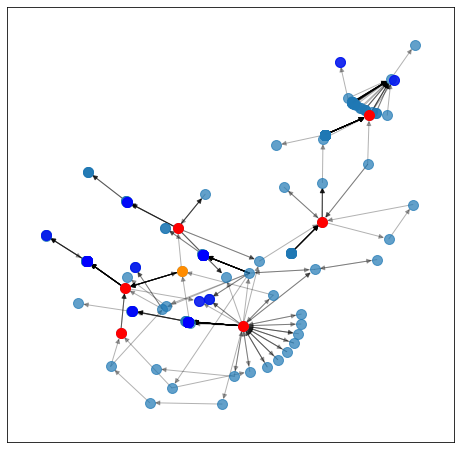

Phishing Gang Num=9


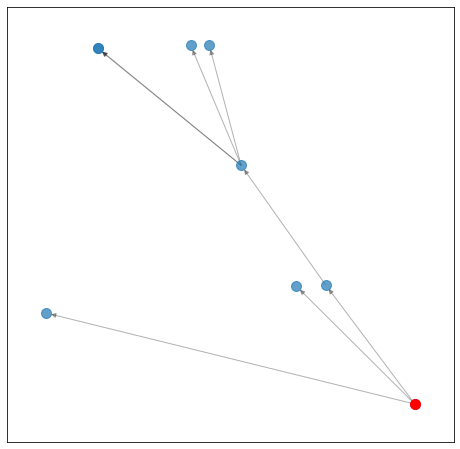

Phishing Gang Num=5


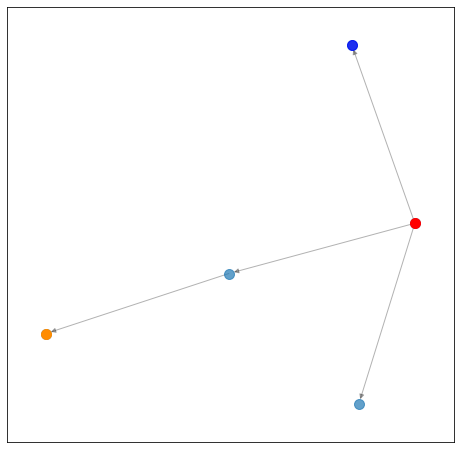

Phishing Gang Num=2


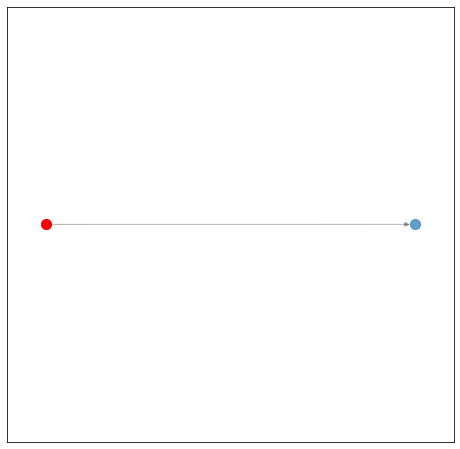

Phishing Gang Num=4


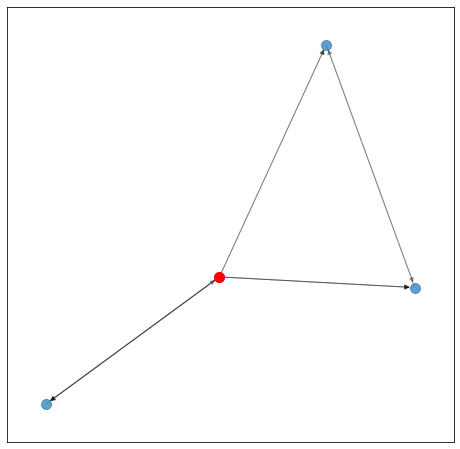

Phishing Gang Num=13


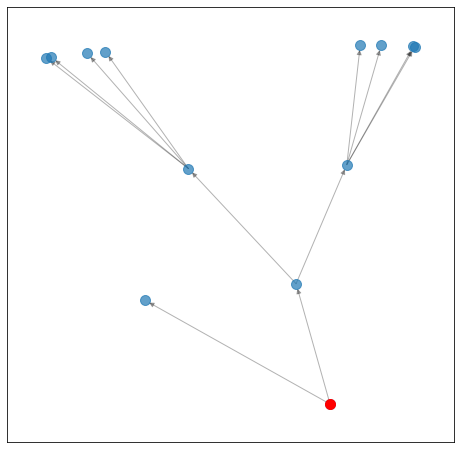

Phishing Gang Num=2


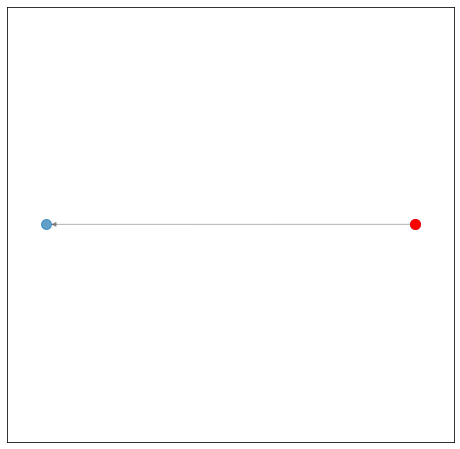

Phishing Gang Num=2


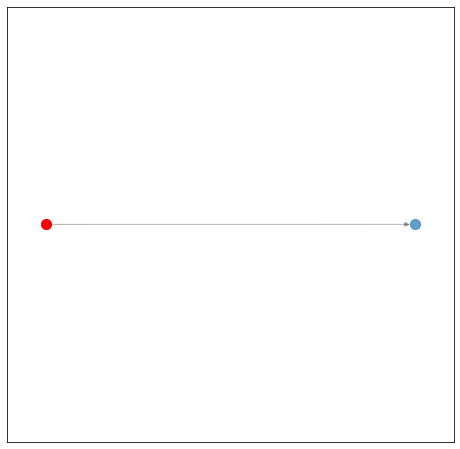

Phishing Gang Num=2


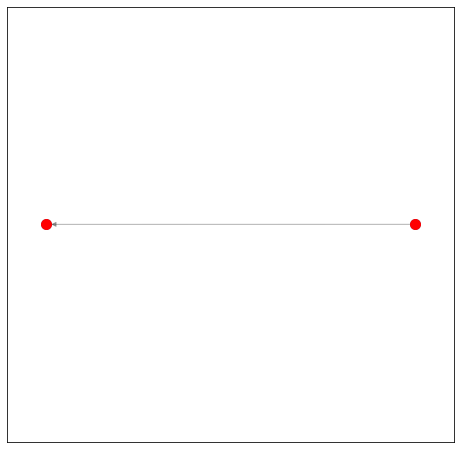

Phishing Gang Num=3


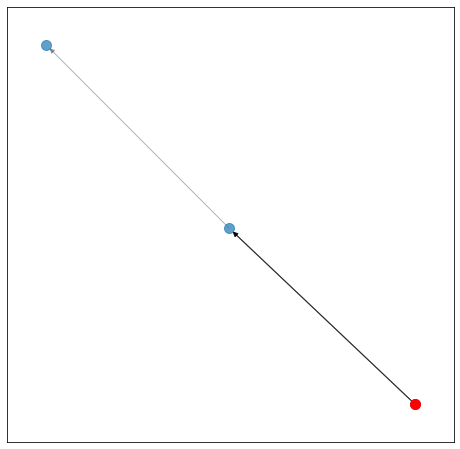

Phishing Gang Num=3


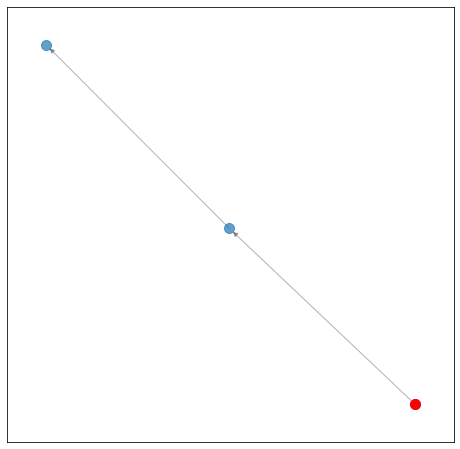

Phishing Gang Num=23


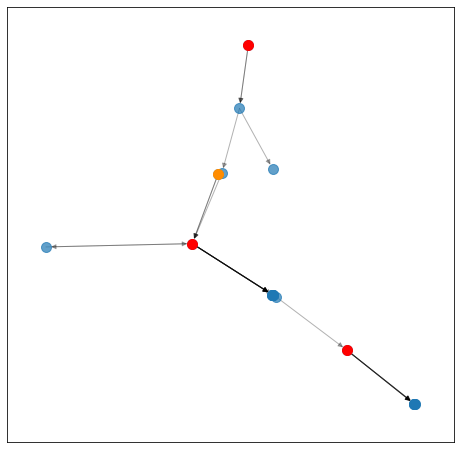

Phishing Gang Num=13


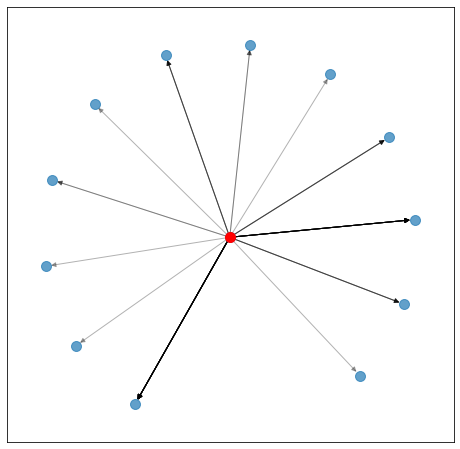

Phishing Gang Num=4


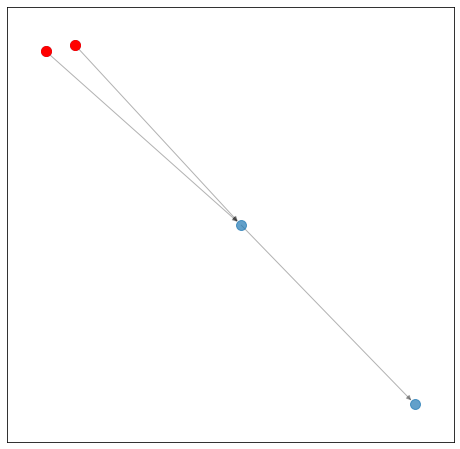

Phishing Gang Num=6


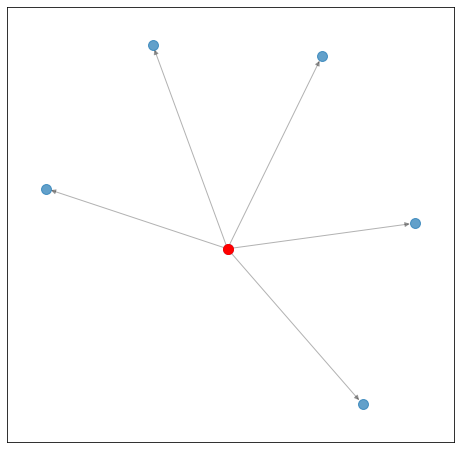

Phishing Gang Num=15


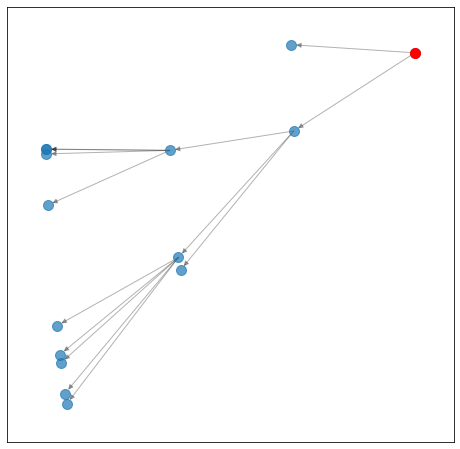

Phishing Gang Num=5


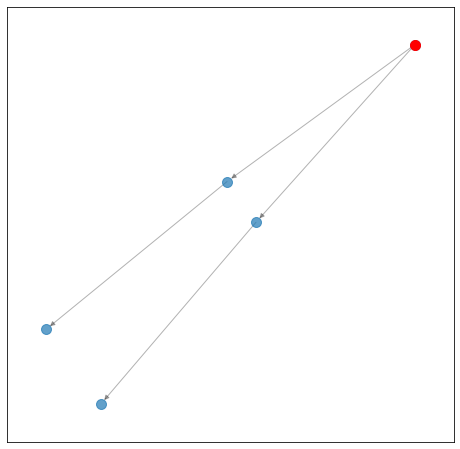

Phishing Gang Num=3


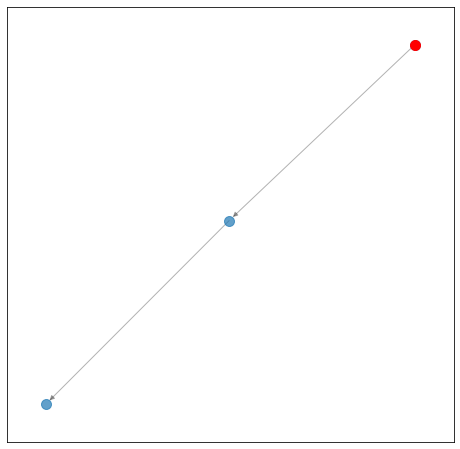

Phishing Gang Num=12


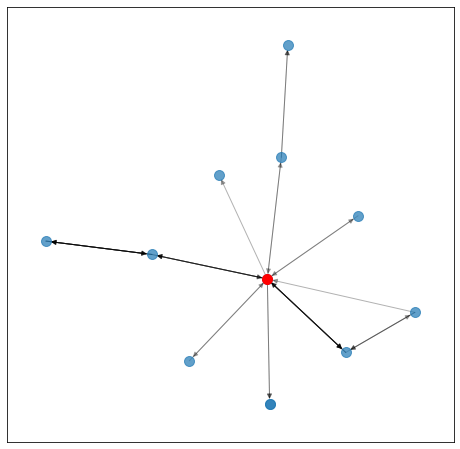

Phishing Gang Num=14


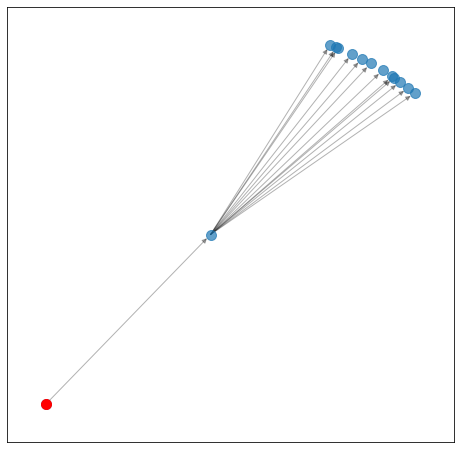

Phishing Gang Num=25


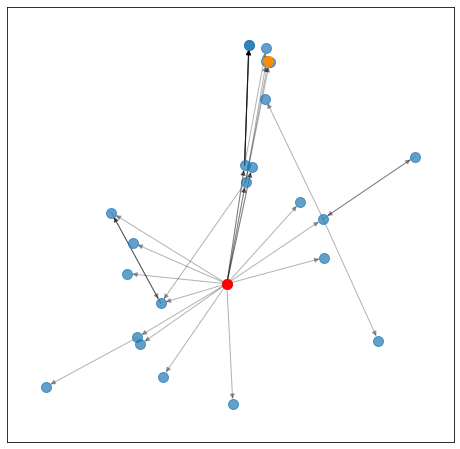

Phishing Gang Num=4


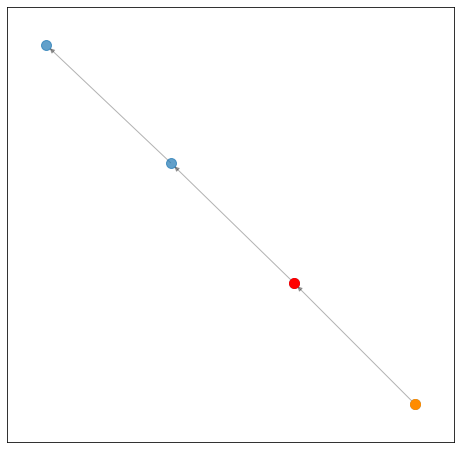

Phishing Gang Num=22


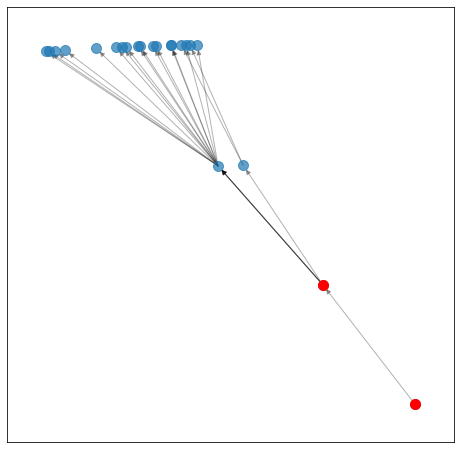

Phishing Gang Num=8


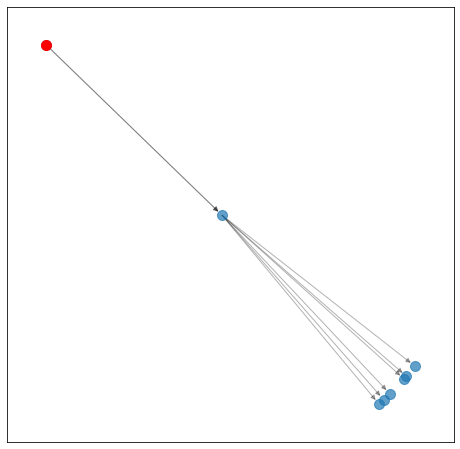

Phishing Gang Num=5


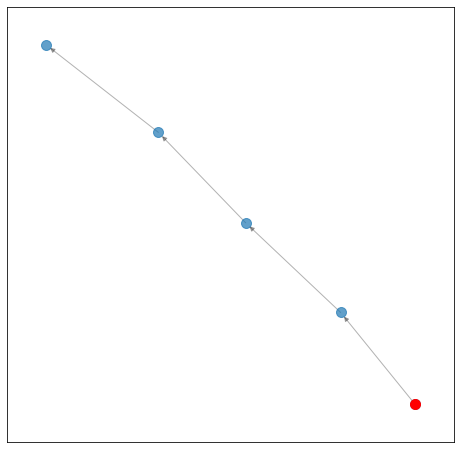

Phishing Gang Num=4


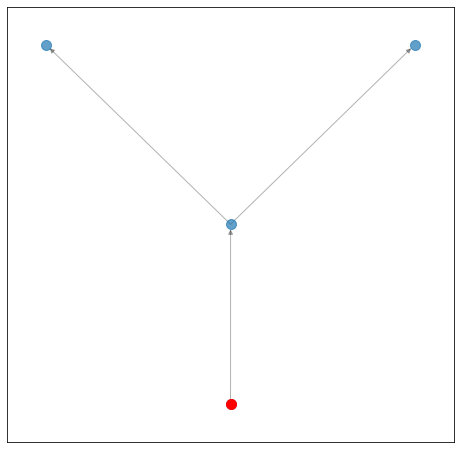

Phishing Gang Num=5


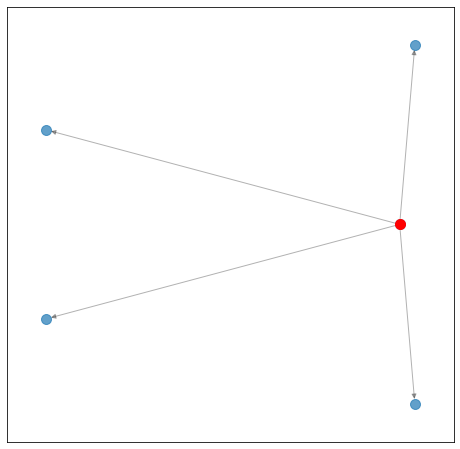

Phishing Gang Num=2


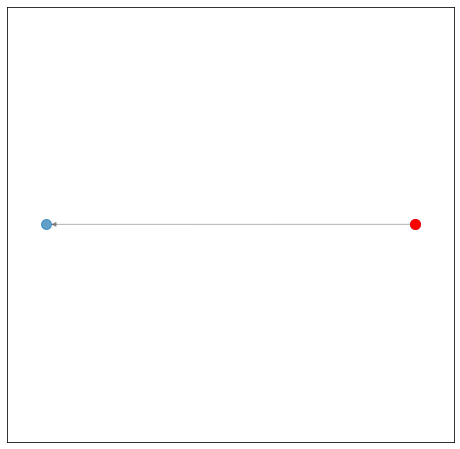

Phishing Gang Num=3


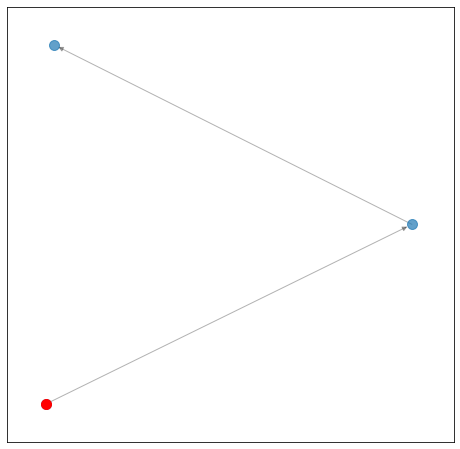

Phishing Gang Num=2


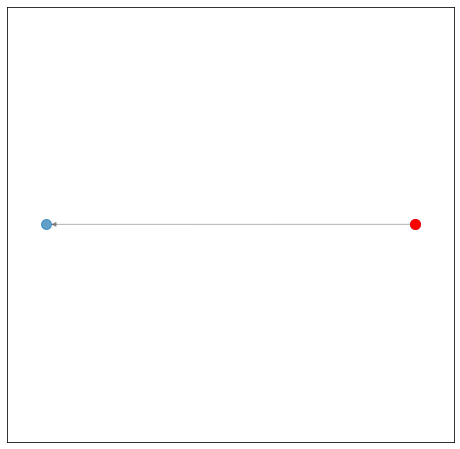

Phishing Gang Num=3


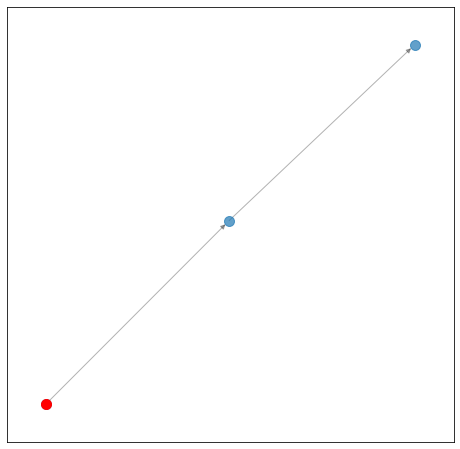

Phishing Gang Num=16


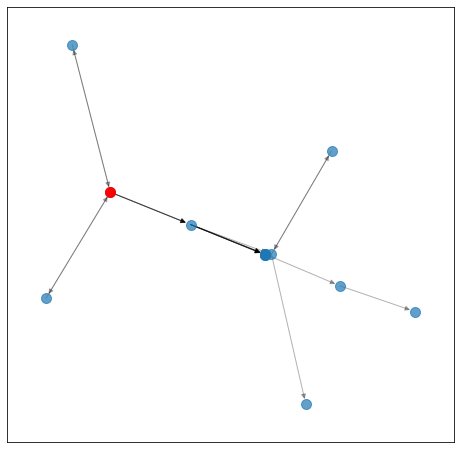

Phishing Gang Num=2


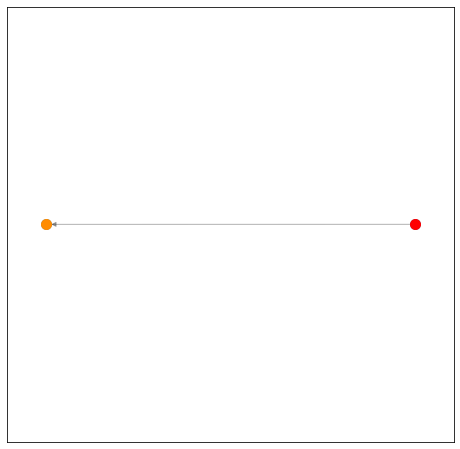

Phishing Gang Num=2


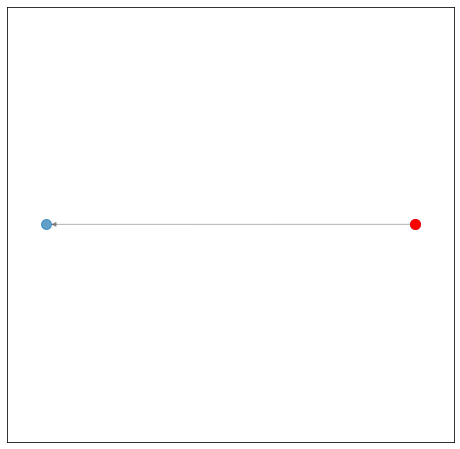

Phishing Gang Num=7


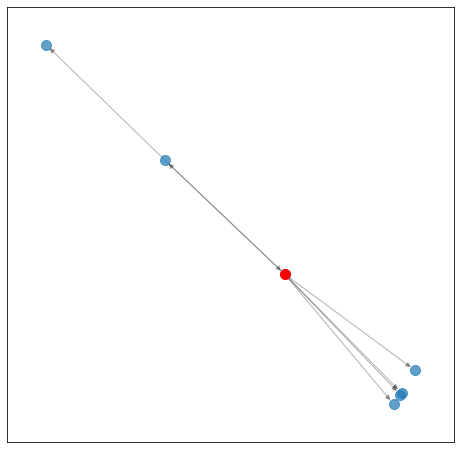

Phishing Gang Num=2


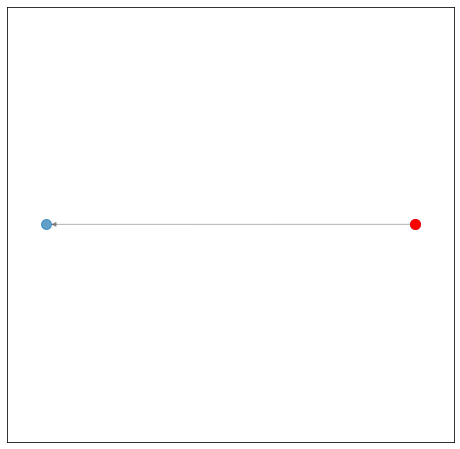

Phishing Gang Num=111


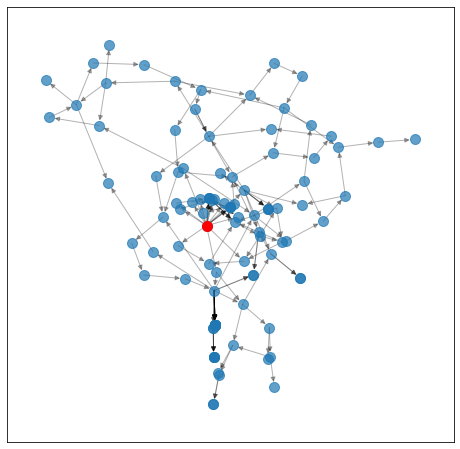

Phishing Gang Num=13


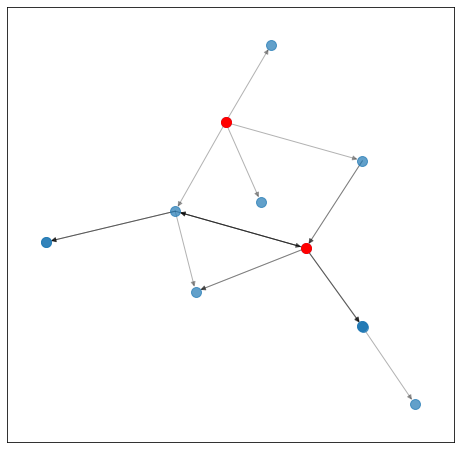

Phishing Gang Num=18


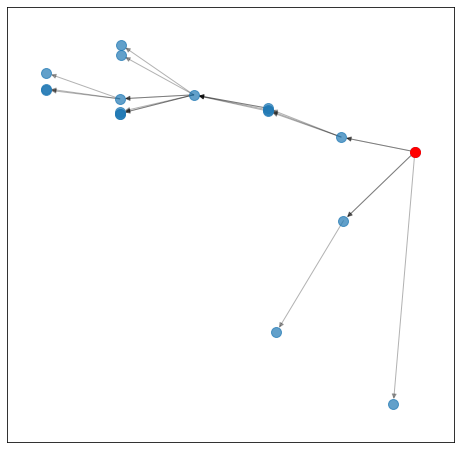

Phishing Gang Num=24


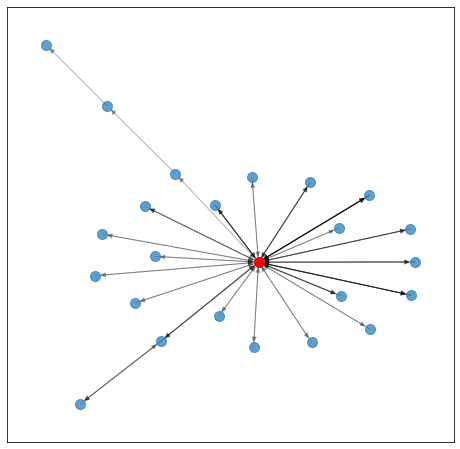

Phishing Gang Num=2


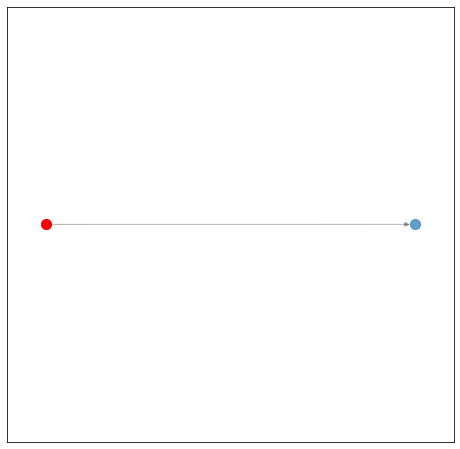

Phishing Gang Num=5


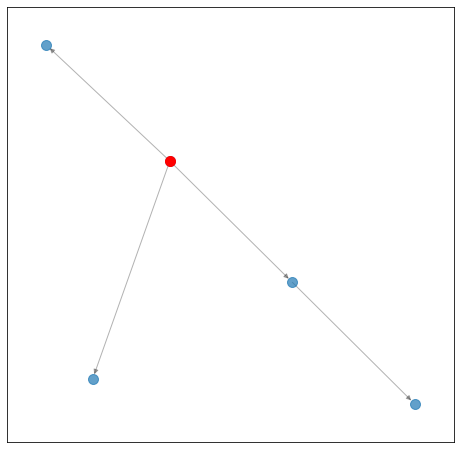

Phishing Gang Num=9


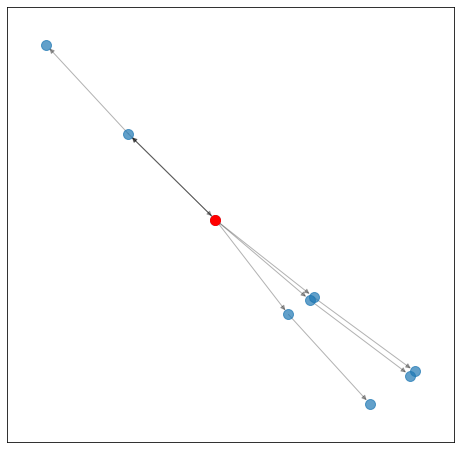

Phishing Gang Num=2


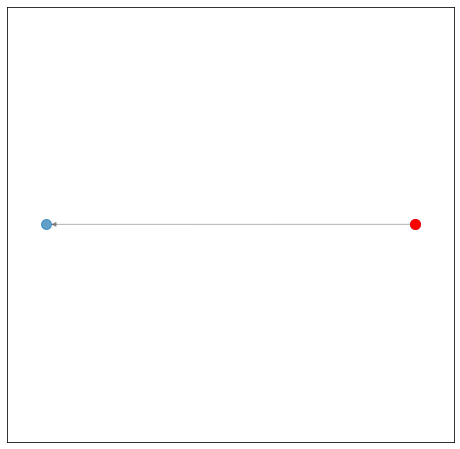

Phishing Gang Num=14


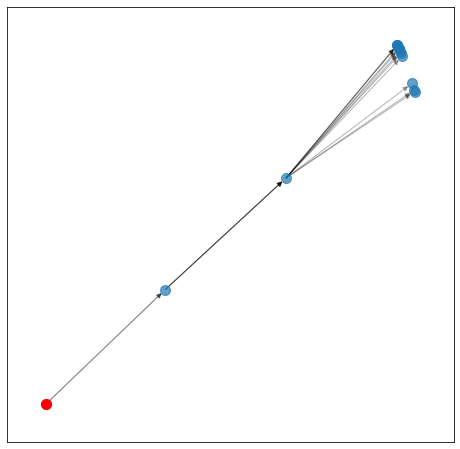

Phishing Gang Num=2


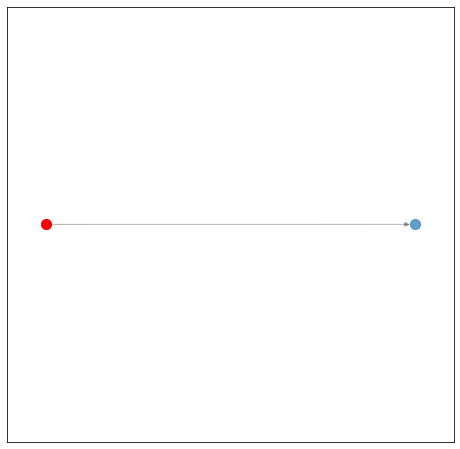

Phishing Gang Num=3


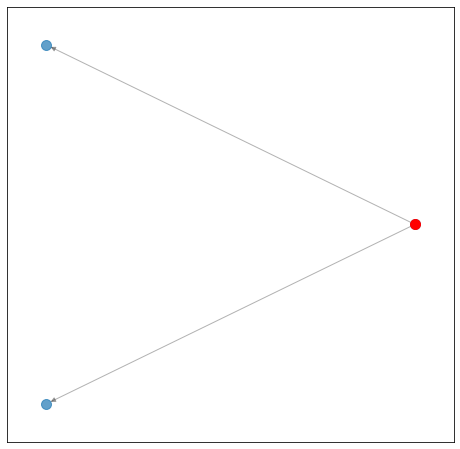

Phishing Gang Num=88


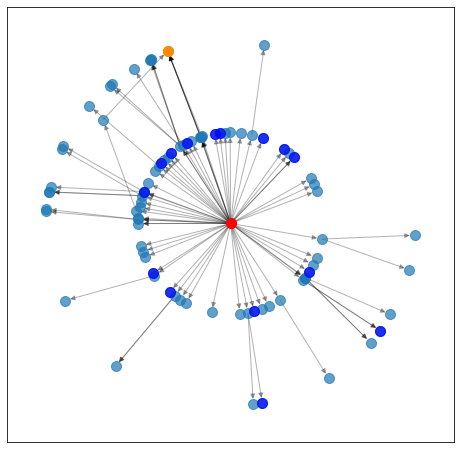

Phishing Gang Num=2


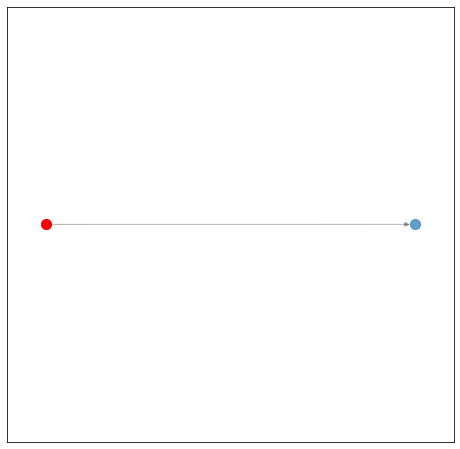

Phishing Gang Num=2


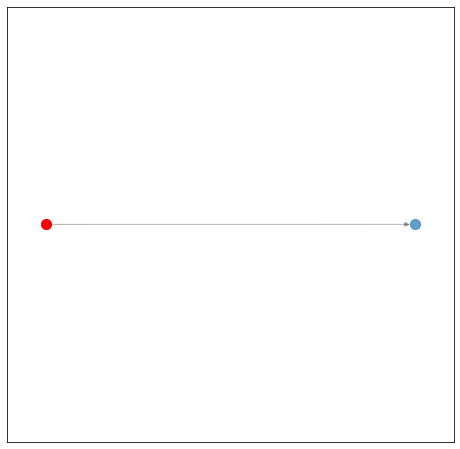

Phishing Gang Num=3


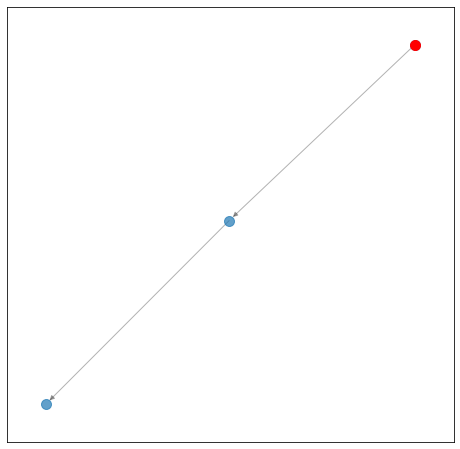

Phishing Gang Num=4


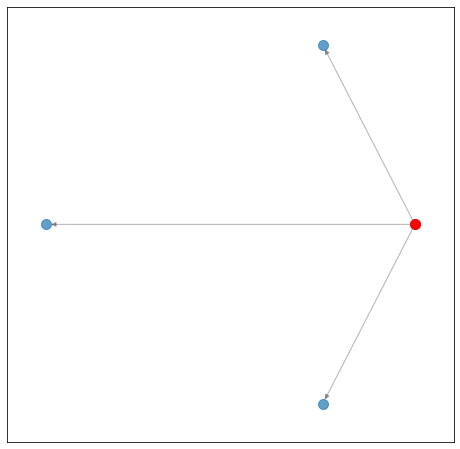

Phishing Gang Num=5


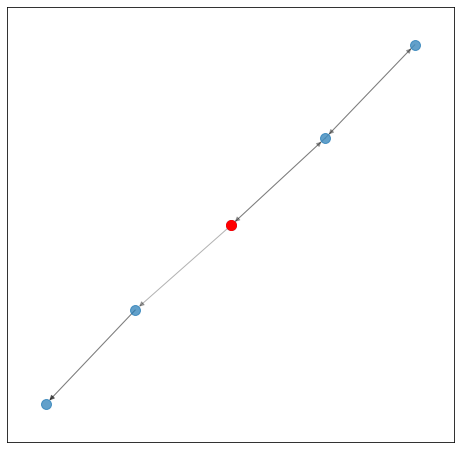

Phishing Gang Num=20


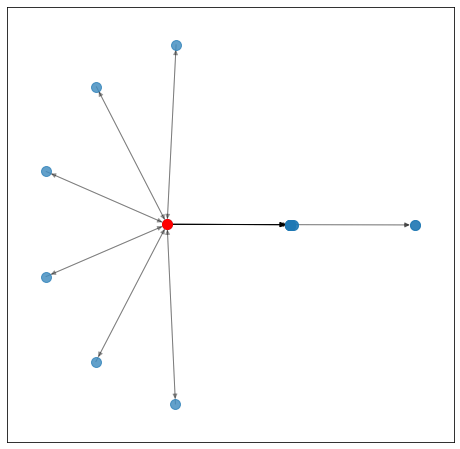

Phishing Gang Num=2


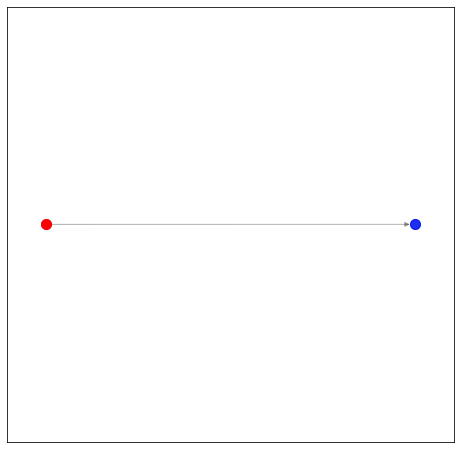

Phishing Gang Num=2


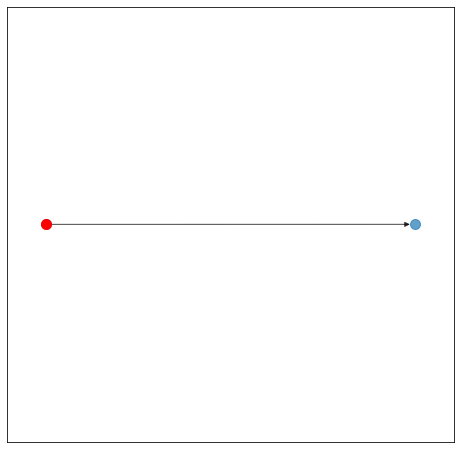

Phishing Gang Num=8


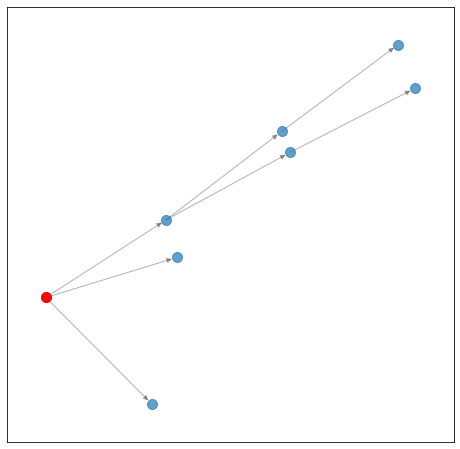

Phishing Gang Num=2


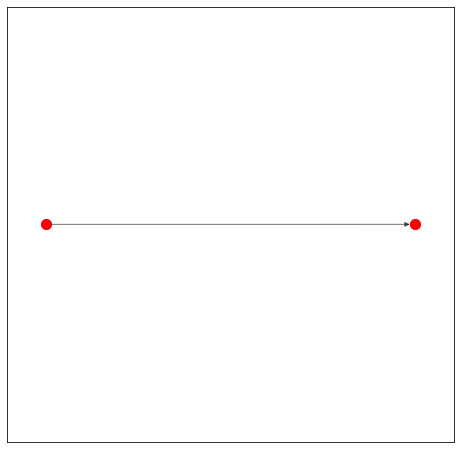

Phishing Gang Num=21


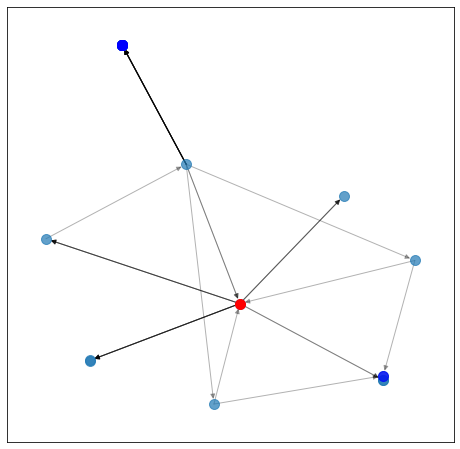

Phishing Gang Num=3


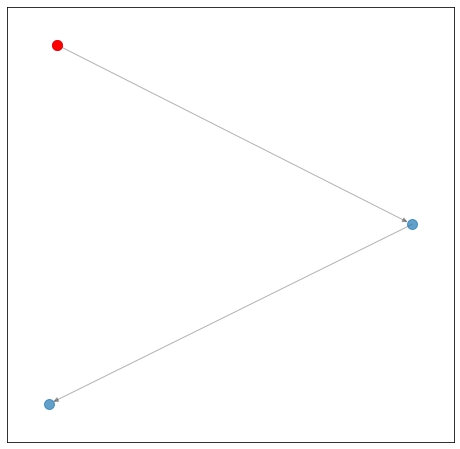

Phishing Gang Num=8


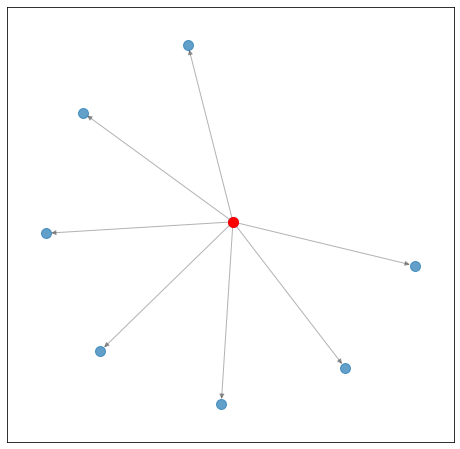

Phishing Gang Num=13


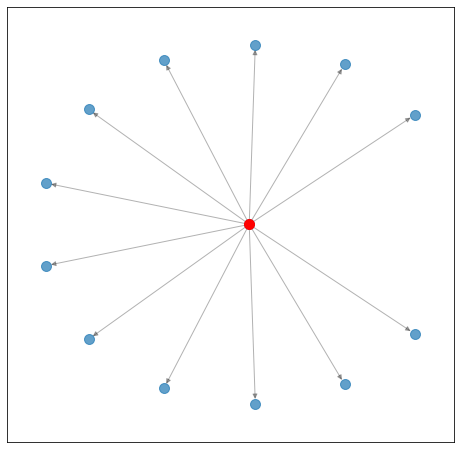

Phishing Gang Num=2


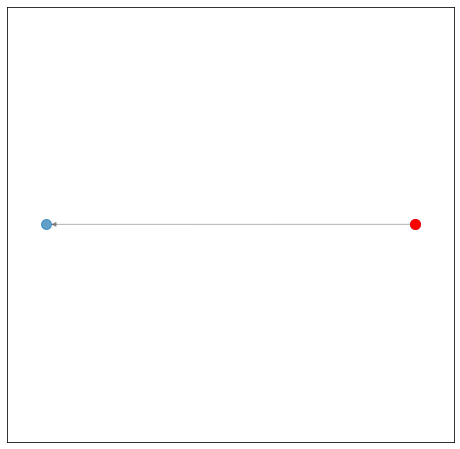

Phishing Gang Num=3


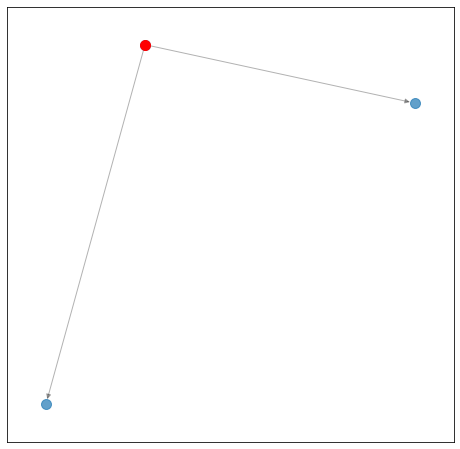

Phishing Gang Num=2


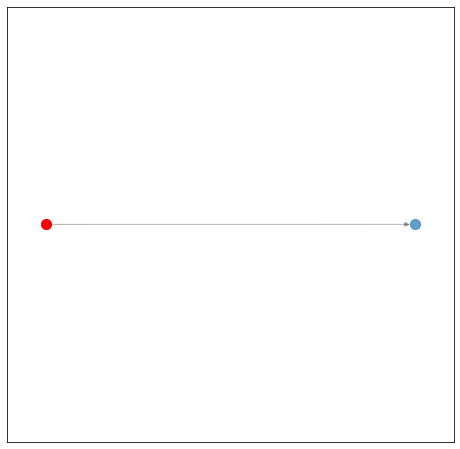

Phishing Gang Num=2


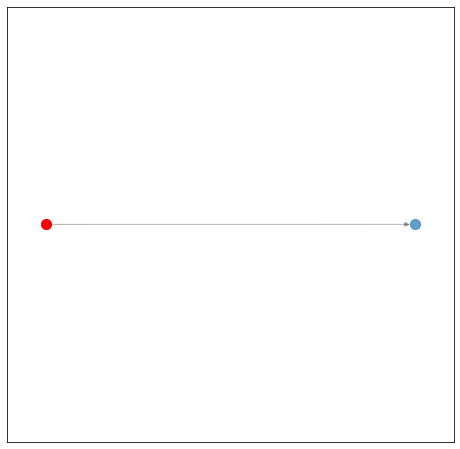

Phishing Gang Num=5


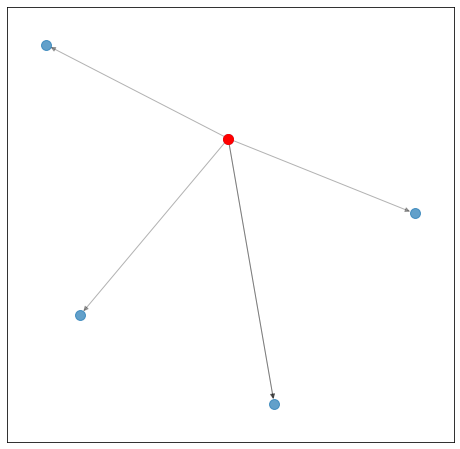

Phishing Gang Num=2


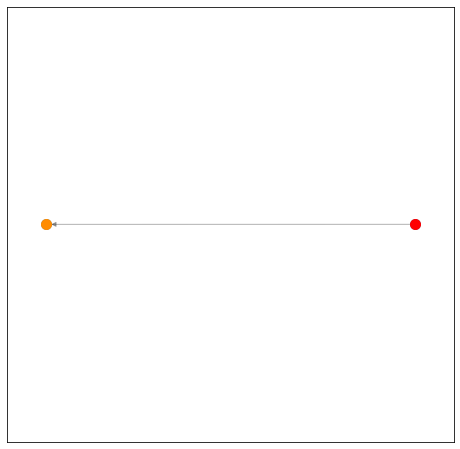

Phishing Gang Num=3


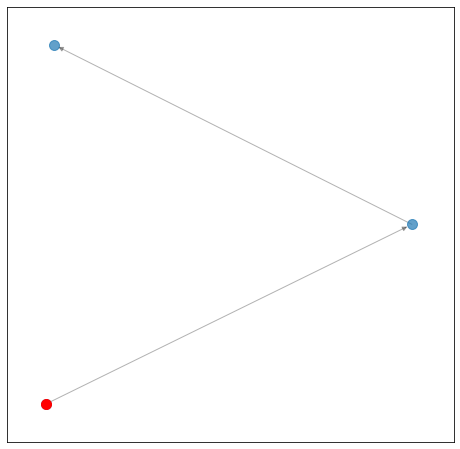

Phishing Gang Num=45


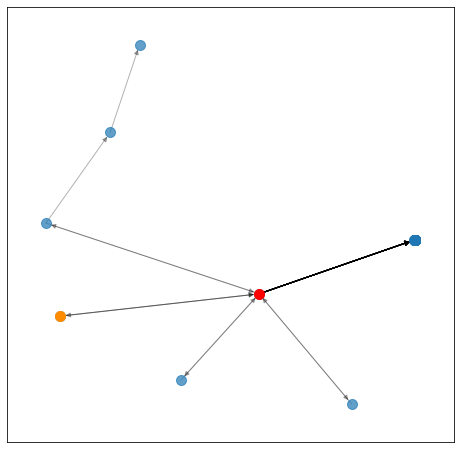

Phishing Gang Num=7


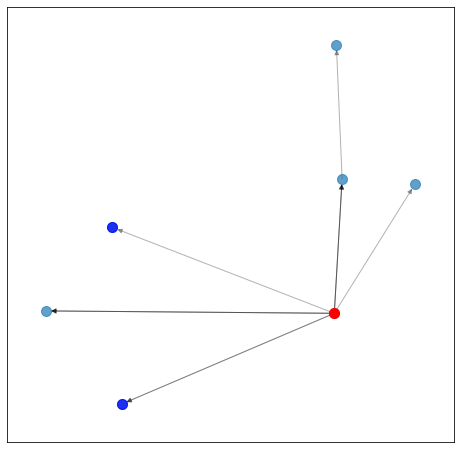

Phishing Gang Num=2


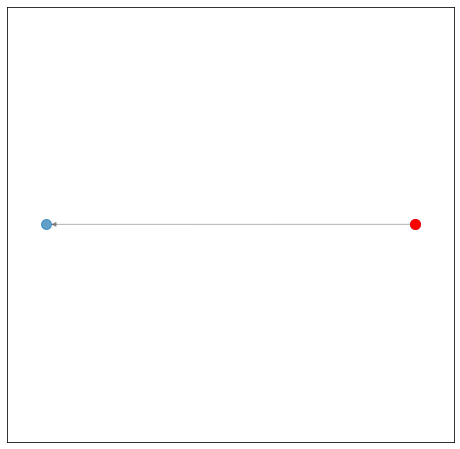

Phishing Gang Num=2


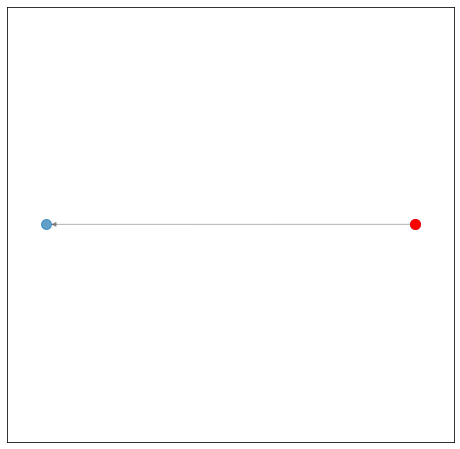

Phishing Gang Num=5


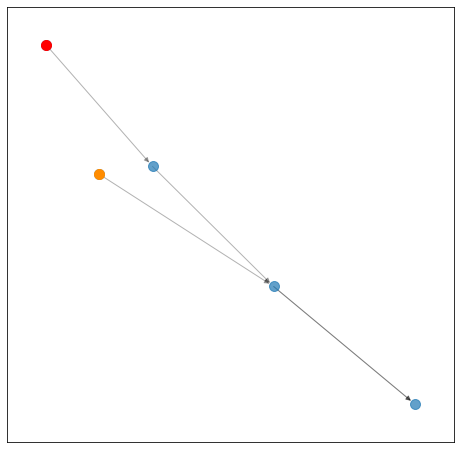

Phishing Gang Num=4


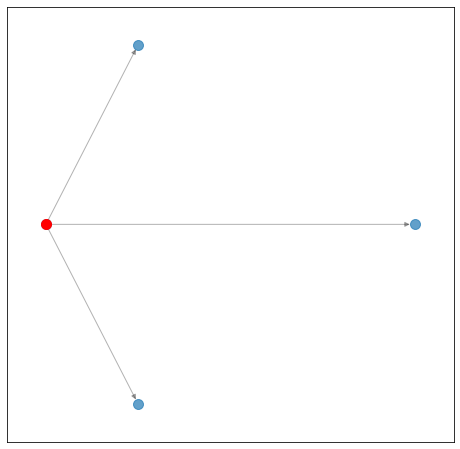

Phishing Gang Num=2


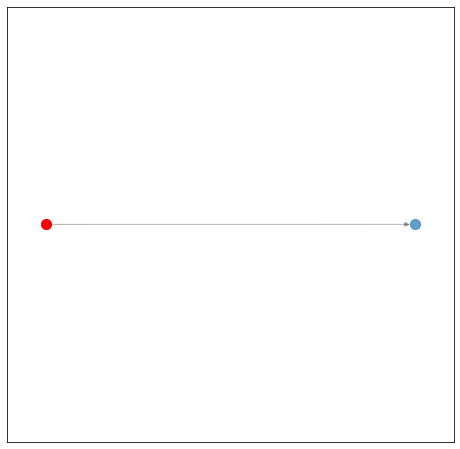

Phishing Gang Num=2


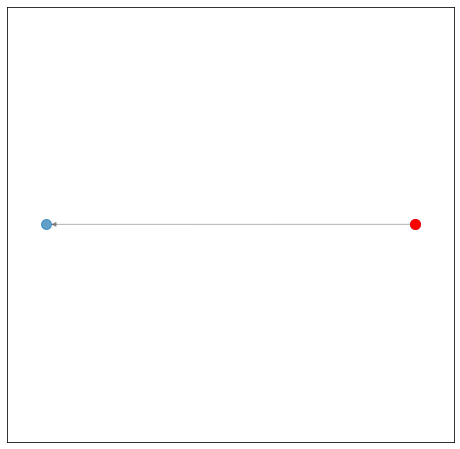

Phishing Gang Num=17


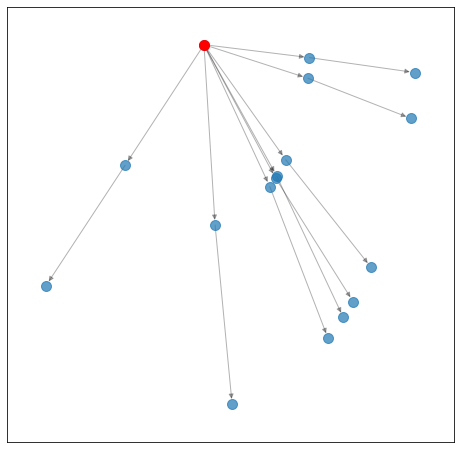

Phishing Gang Num=21


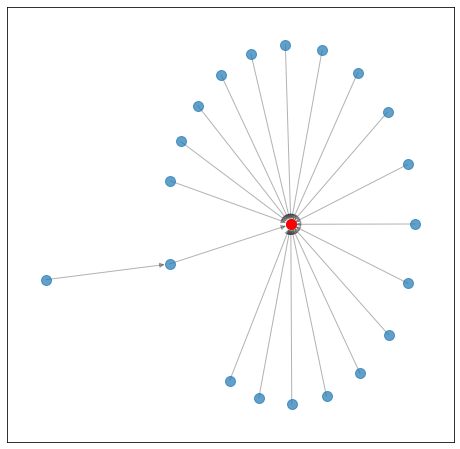

Phishing Gang Num=18


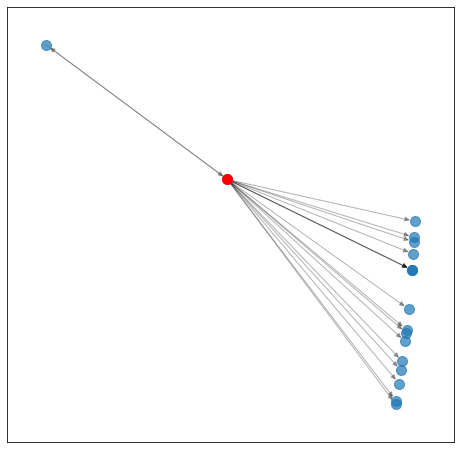

Phishing Gang Num=2


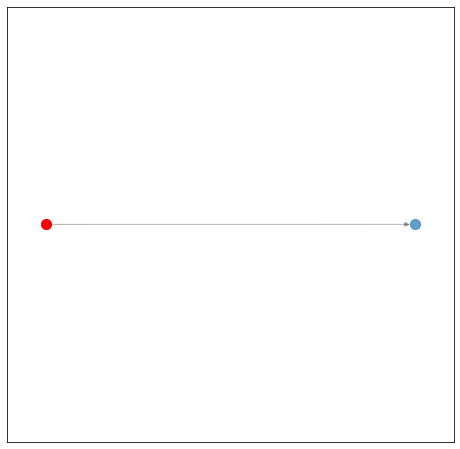

Phishing Gang Num=16


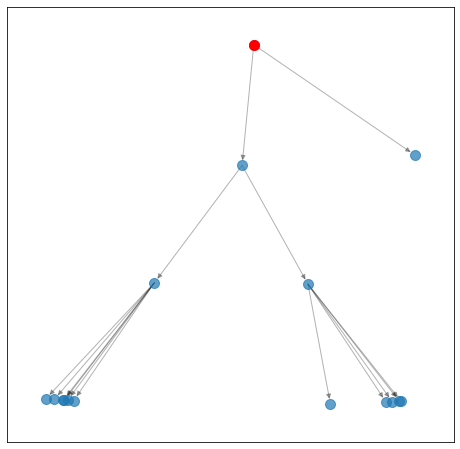

Phishing Gang Num=3


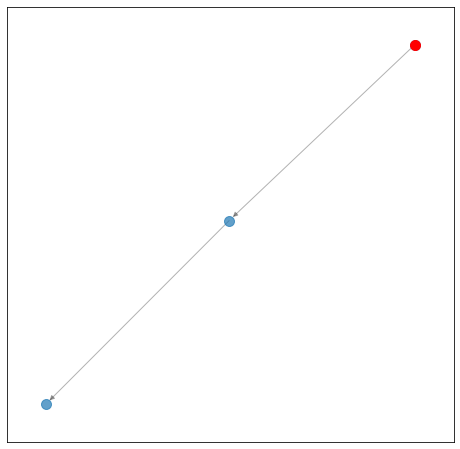

Phishing Gang Num=3


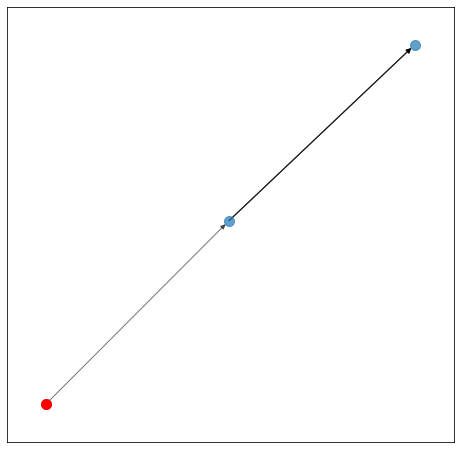

Phishing Gang Num=5


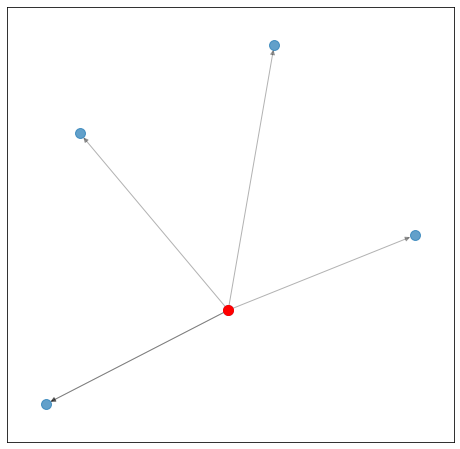

Phishing Gang Num=2


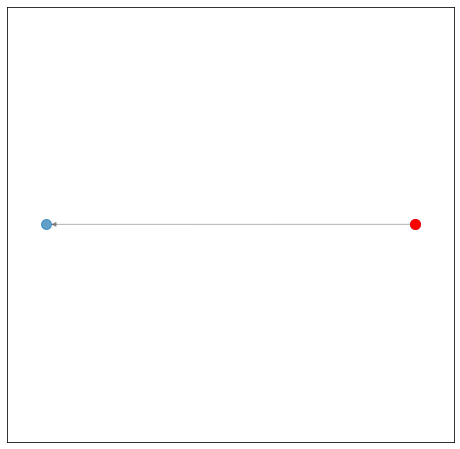

Phishing Gang Num=2


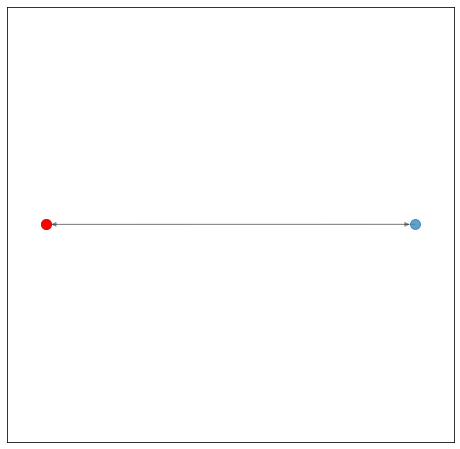

Phishing Gang Num=2


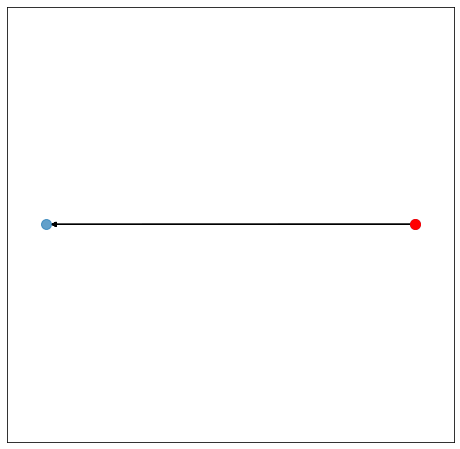

Phishing Gang Num=2


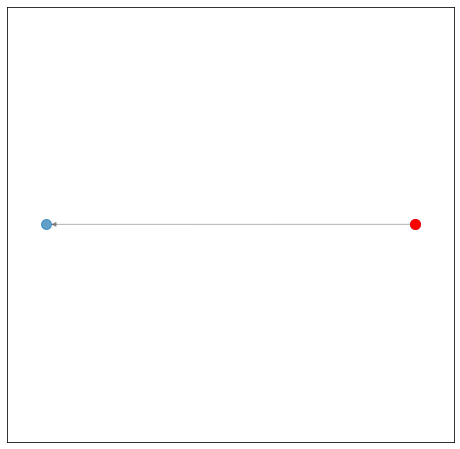

Phishing Gang Num=9


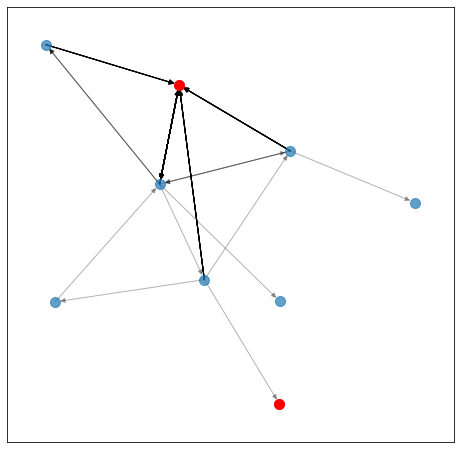

Phishing Gang Num=6


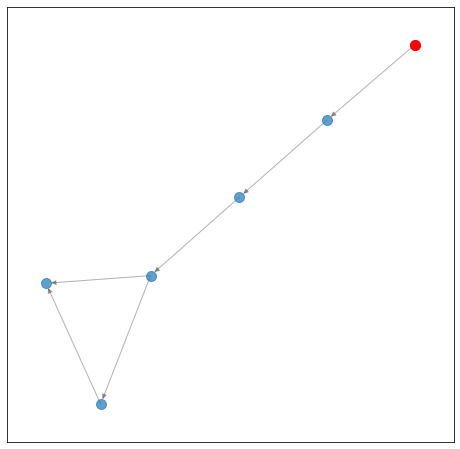

Phishing Gang Num=2


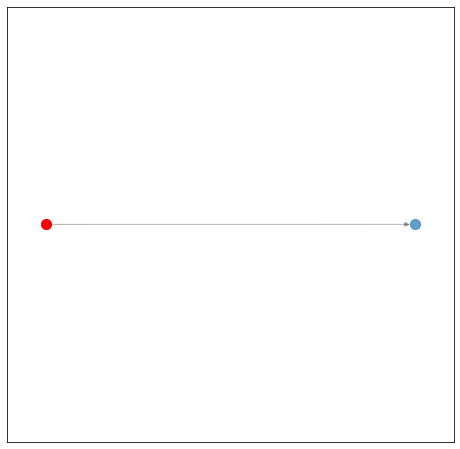

Phishing Gang Num=3


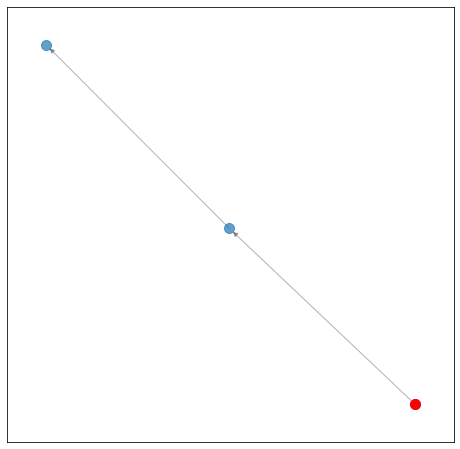

Phishing Gang Num=5


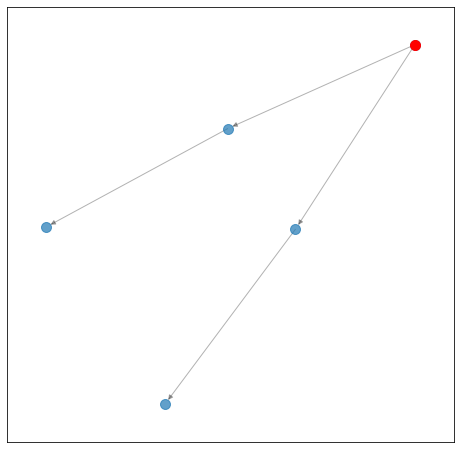

Phishing Gang Num=3


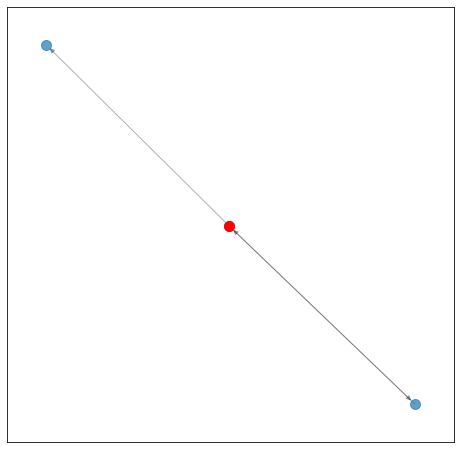

Phishing Gang Num=11


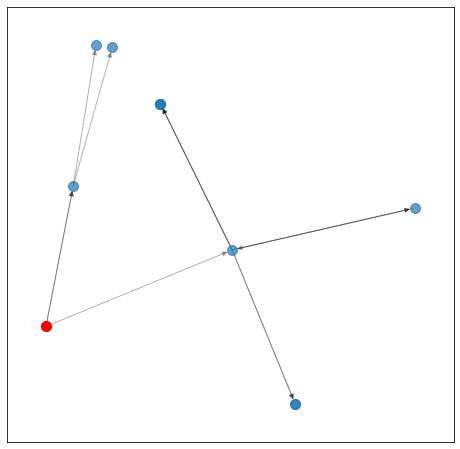

Phishing Gang Num=15


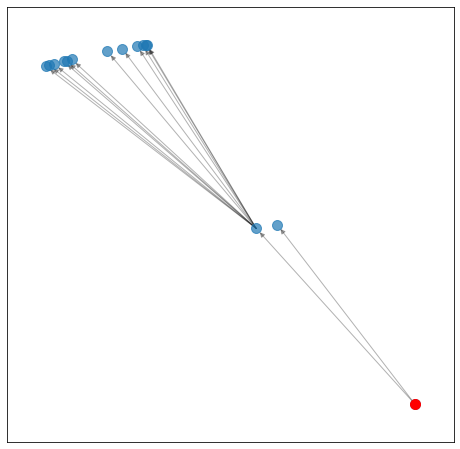

Phishing Gang Num=8


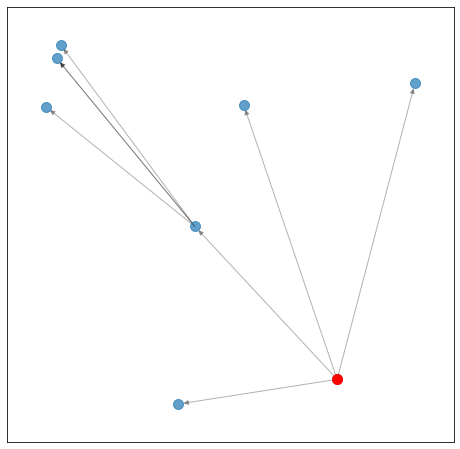

Phishing Gang Num=6


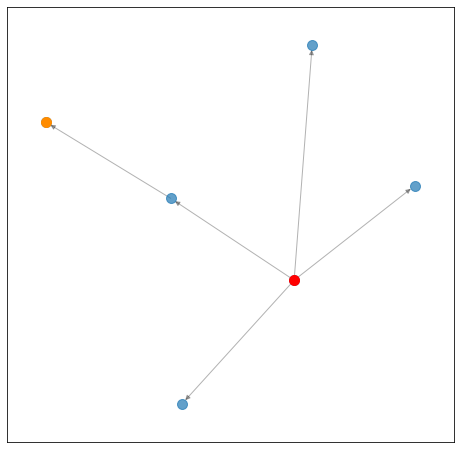

Phishing Gang Num=4


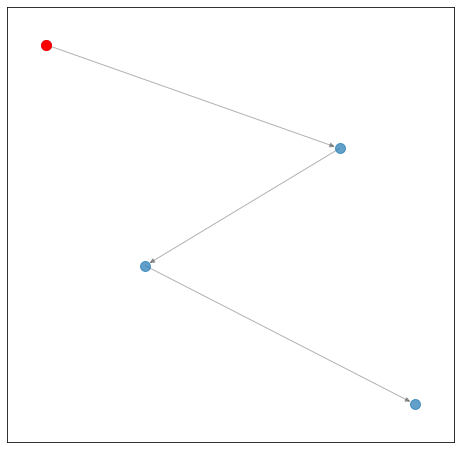

Phishing Gang Num=4


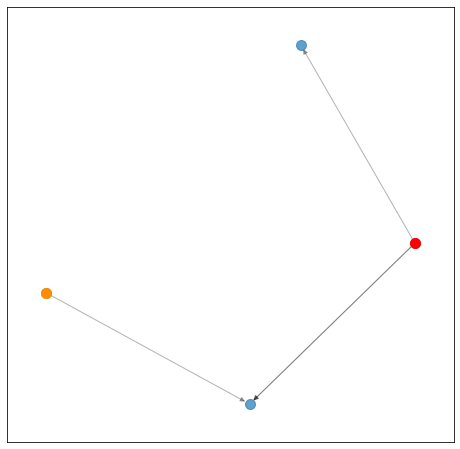

Phishing Gang Num=2


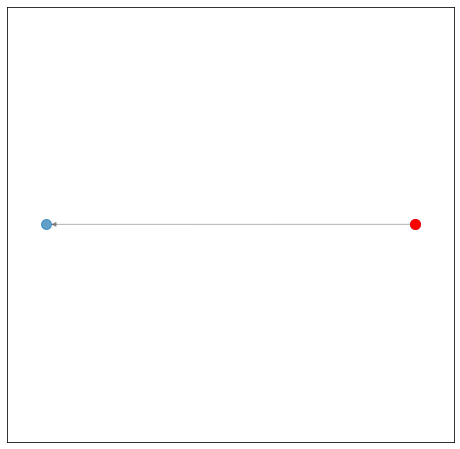

Phishing Gang Num=2


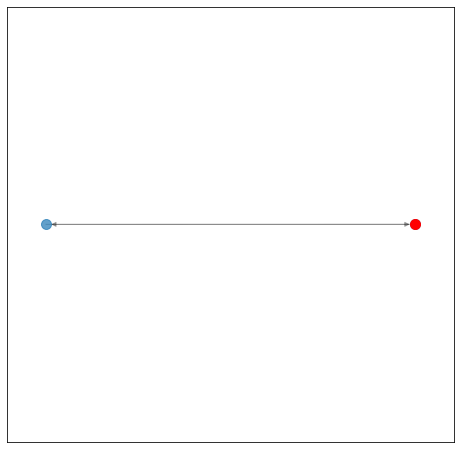

Phishing Gang Num=2


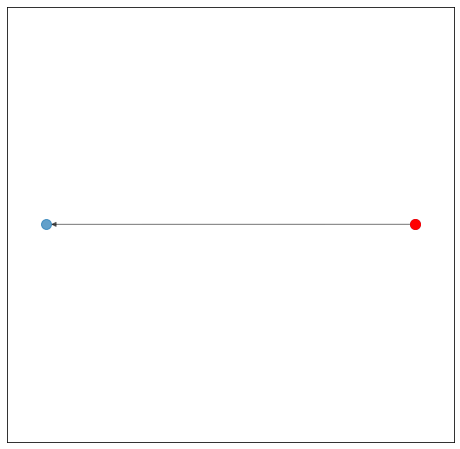

Phishing Gang Num=4


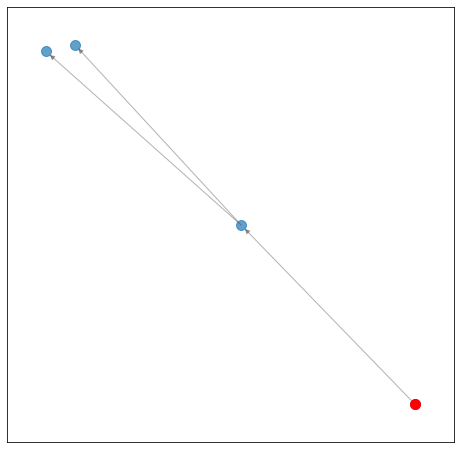

Phishing Gang Num=5


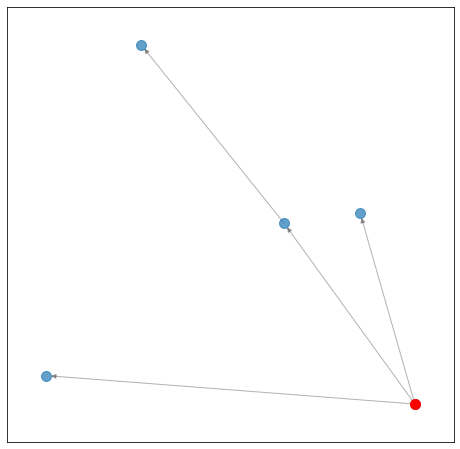

Phishing Gang Num=2


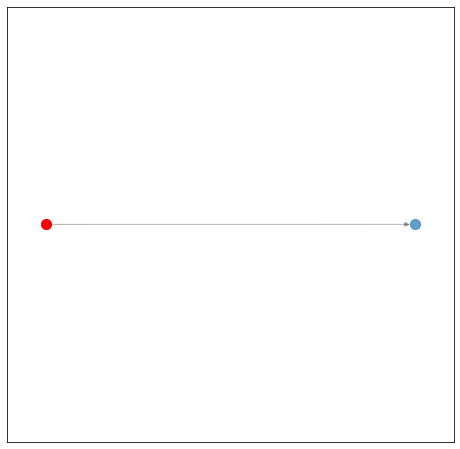

Phishing Gang Num=2


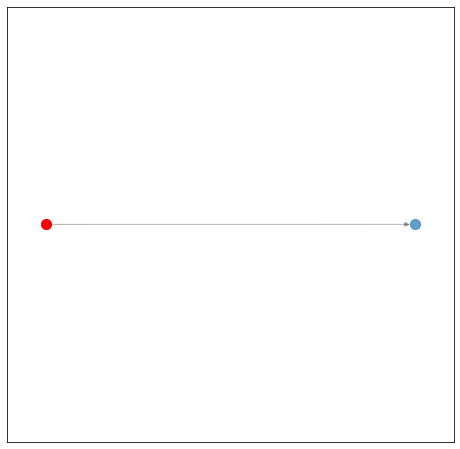

Phishing Gang Num=6


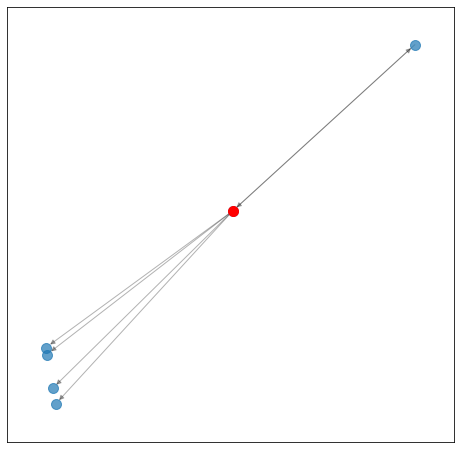

Phishing Gang Num=2


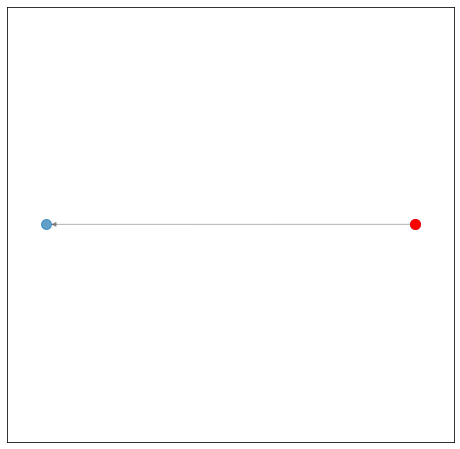

Phishing Gang Num=14


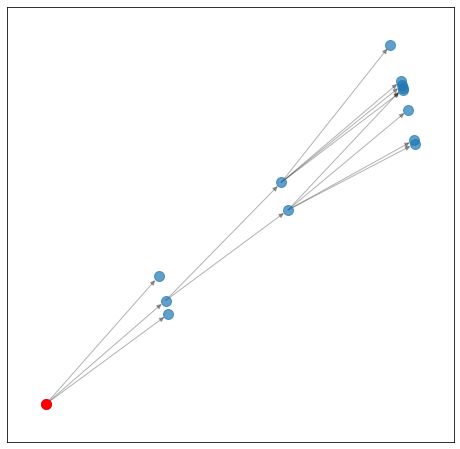

Phishing Gang Num=2


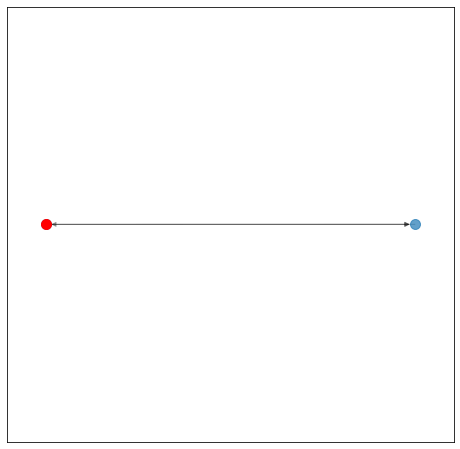

Phishing Gang Num=11


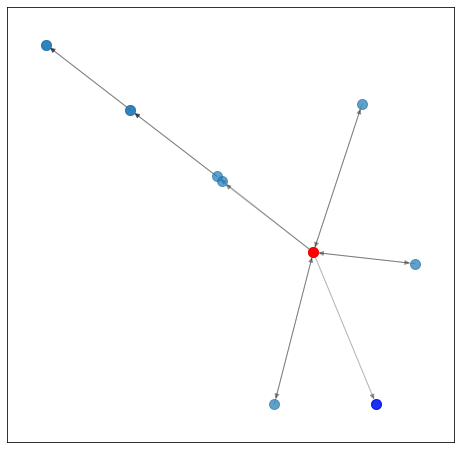

Phishing Gang Num=2


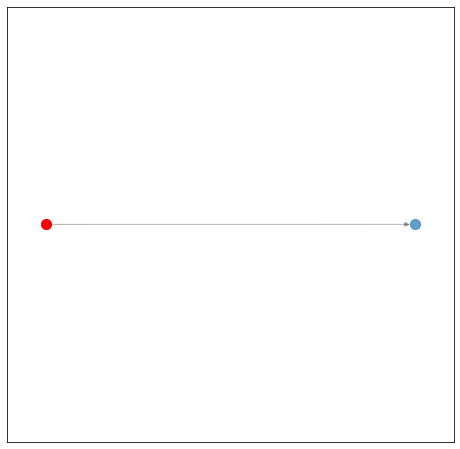

In [48]:
for gang in phishing_gang_sets3:
    if len(gang)>1:
        draw_gang_graph(gang)

In [49]:
phishing_gang_sets3=sorted(phishing_gang_sets3,key=lambda x:len(x))
print([len(gang) for gang in phishing_gang_sets3])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 8, 8, 8, 8, 9, 9, 9, 10, 11, 11, 12, 13, 13, 13, 13, 13, 14, 14, 14, 15, 15, 16, 16, 17, 18, 18, 18, 20, 21, 21, 22, 23, 24, 25, 45, 56, 77, 88, 111, 178, 217, 334]


In [50]:
print([phishing_gang_sets2.count(gang) for gang in phishing_gang_sets3])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 3, 1, 1, 11, 6, 11]


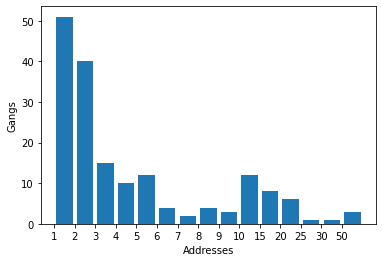

In [51]:
#plot CCDF
bins=list(range(1,10))+[10,15,20,25,30,50,100]
hist,bin_edges = np.histogram([len(gang) for gang in phishing_gang_sets3],bins) # make the histogram
plt.ylabel('Gangs')
plt.xlabel('Addresses')
# # Plot the histogram heights against integers on the x axis
plt.bar(range(len(hist)),hist,width=0.8) 
# # Set the ticks to the middle of the bars
plt.xticks([i-0.5 for i,j in enumerate(hist)],['{}'.format(bins[i]) for i,j in enumerate(hist)])                                            
plt.show()

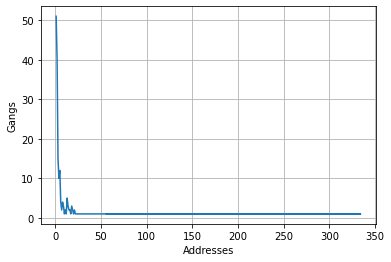

In [52]:
phishing_gang_nums=[len(gang) for gang in phishing_gang_sets3]
plt.plot(list(set(phishing_gang_nums)),[phishing_gang_nums.count(num) for num in set(phishing_gang_nums)])
plt.ylabel('Gangs')
plt.xlabel('Addresses')
plt.grid(True)
plt.show()

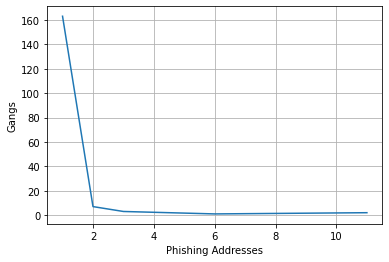

In [53]:
phishing_gang_pnums=[phishing_gang_sets2.count(gang) for gang in phishing_gang_sets3]
plt.plot(list(set(phishing_gang_pnums)),[phishing_gang_pnums.count(pnum) for pnum in set(phishing_gang_pnums)])
plt.ylabel('Gangs')
plt.xlabel('Phishing Addresses')
plt.grid(True)
plt.show()

In [54]:
accum_address=[nd for idx,nd in enumerate(G2.nodes) if G2.nodes[nd]['label']=='A']
accum_address_ingang=[nd for gang in phishing_gang_sets3 for nd in gang if G2.nodes[nd]['label']=='A']
print(len(accum_address),len(accum_address_ingang))

35487 23


In [55]:
print(len(set(accum_address_ingang)))
print([nd for nd in accum_address_ingang if accum_address_ingang.count(nd)>1])

22
['0x2e8e5f34fd0e67dc6c8d3108d5de2dd760ae2846', '0x2e8e5f34fd0e67dc6c8d3108d5de2dd760ae2846']


In [56]:
one_gang=[gang for gang in phishing_gang_sets3 if len(gang)==1]
small_gang=[gang for gang in phishing_gang_sets3 if len(gang)>1 and len(gang)<10]
middle_gang=[gang for gang in phishing_gang_sets3 if len(gang)>=10 and len(gang)<99]
big_gang=[gang for gang in phishing_gang_sets3 if len(gang)>=99]

In [57]:
print(len(one_gang),len(small_gang),len(middle_gang))

51 90 31


In [58]:
low_common_address=[nd for idx,nd in enumerate(G2.nodes) if G2.nodes[nd]['label']=='LC']
high_common_address=[nd for idx,nd in enumerate(G2.nodes) if G2.nodes[nd]['label']=='HC']
print(len(low_common_address),len(high_common_address))

9553780 3575


In [59]:
bridge_address=[nd for idx,nd in enumerate(G2.nodes) if G2.nodes[nd]['label']=='B']
Token_address=[nd for idx,nd in enumerate(G2.nodes) if G2.nodes[nd]['label']=='T']
Exchange_address=[nd for idx,nd in enumerate(G2.nodes) if G2.nodes[nd]['label']=='E']
print(len(bridge_address),len(Token_address),len(Exchange_address))

1916 56 133


In [60]:
def get_laundry_group(gang):
    for idx,nd in enumerate(G2.nodes):
        G2.nodes[nd]['visited']=False
    laundry_group=set()
    mates=gang.copy()
    while len(mates)!=0:
        a=mates.pop()
        G2.nodes[a]['visited']=True
        end_set=set()
        for nd in G2.succ[a]:
            if not G2.nodes[nd]['visited']:
                if G2.nodes[nd]['label'] in ['E','T','HC','LC','A']:
                    end_set.add(nd)
                    G2.nodes[nd]['visited']=True                
                else:
                    mates.add(nd)
        laundry_group.add(a)
        laundry_group=laundry_group|end_set
#         print(end_set)
    return laundry_group.copy()

In [61]:
laundry_groups=[]
for gang in phishing_gang_sets3:
    laundry_group=get_laundry_group(gang)
    laundry_groups.append(laundry_group)
    print('('+str(len(gang))+','+str(len(laundry_group))+')',end=' ')

(1,1) (1,1) (1,1) (1,2) (1,1) (1,2) (1,1) (1,1) (1,2) (1,2) (1,1) (1,2) (1,3) (1,1) (1,1) (1,1) (1,2) (1,2) (1,1) (1,1) (1,2) (1,2) (1,1) (1,1) (1,2) (1,1) (1,2) (1,2) (1,1) (1,2) (1,1) (1,1) (1,2) (1,1) (1,1) (1,1) (1,1) (1,1) (1,3) (1,3) (1,1) (1,2) (1,1) (1,2) (1,4) (1,2) (1,1) (1,2) (1,1) (1,2) (1,1) (2,2) (2,3) (2,3) (2,3) (2,2) (2,3) (2,3) (2,11) (2,3) (2,3) (2,3) (2,3) (2,3) (2,4) (2,3) (2,2) (2,3) (2,2) (2,4) (2,4) (2,3) (2,19) (2,3) (2,4) (2,3) (2,4) (2,3) (2,2) (2,2) (2,2) (2,3) (2,3) (2,3) (2,2) (2,2) (2,3) (2,6) (2,3) (2,2) (2,3) (3,7) (3,4) (3,4) (3,11) (3,5) (3,4) (3,4) (3,4) (3,4) (3,6) (3,5) (3,4) (3,4) (3,5) (3,7) (4,5) (4,4) (4,5) (4,7) (4,7) (4,9) (4,6) (4,7) (4,8) (4,6) (5,7) (5,9) (5,6) (5,6) (5,7) (5,9) (5,14) (5,5) (5,9) (5,22) (5,6) (5,8) (6,14) (6,7) (6,14) (6,7) (7,9) (7,9) (8,9) (8,9) (8,18) (8,25) (9,12) (9,10) (9,11) (10,13) (11,18) (11,13) (12,17) (13,14) (13,15) (13,20) (13,17) (13,14) (14,15) (14,45) (14,15) (15,16) (15,16) (16,22) (16,17) (17,18) (18,19

In [85]:
import random
def set_pos(phishing_gang,laundry_group):
    pos=dict()
    #label proflie
    phishs=set([nd for nd in laundry_group if G2.nodes[nd]['label']=='P'])
    accums_g=set([nd for nd in phishing_gang if G2.nodes[nd]['label']=='A'])
    first_layer_nodes=phishs|accums_g
    second_layer_nodes=set([nd for nd in laundry_group if G2.nodes[nd]['label'] in ['B','H']])
    third_layer_nodes=laundry_group-first_layer_nodes-second_layer_nodes
    #set pos
    first_layer_pos=[(x,y) for x in range(5,150,5) for y in range(95,120,5)]
    for nd in first_layer_nodes:
        cord=random.choice(first_layer_pos)
        first_layer_pos.remove(cord)
        pos[nd]=cord
    second_layer_pos1=[(x,y) for x in range(5,120,5) for y in range(35,90,5)]
    second_layer_pos2=[(x,y) for x in range(125,150,5) for y in range(35,90,5)]    
    for nd in second_layer_nodes:
        if G2.nodes[nd]['is_inact']==1:
            cord=random.choice(second_layer_pos2)
            second_layer_pos2.remove(cord)
        else:
            cord=random.choice(second_layer_pos1)
            second_layer_pos1.remove(cord)
        pos[nd]=cord
    third_layer_pos1=[(x,y) for x in range(5,120,5) for y in range(5,30,5)]
    third_layer_pos2=[(x,y) for x in range(125,150,5) for y in range(5,30,5)]
    for nd in third_layer_nodes:
        if G2.nodes[nd]['label'] in ('E','T'):
            cord=random.choice(third_layer_pos2)
            third_layer_pos2.remove(cord)
        else:
            cord=random.choice(third_layer_pos1)
            third_layer_pos1.remove(cord)
        pos[nd]=cord
    return pos.copy()

def draw_laundry_graph(phishing_gang,laundry_group):
    sub_graph=nx.MultiDiGraph()
    sub_graph=nx.union(sub_graph,G2.subgraph(laundry_group))
    print('Phishing Gang',"Num="+str(len(phishing_gang)))
    nodes_label={key:[] for key in ['E','T','HC','LC','A','B','P','H']}
    for nd in laundry_group:
        nodes_label[sub_graph.nodes[nd]['label']].append(nd)
    in_actives=[nd for nd in laundry_group if sub_graph.nodes[nd]['is_inact']==1]
    plt.figure(figsize=(5,4))
    pos=set_pos(phishing_gang,laundry_group)
    nx.draw_networkx_nodes(sub_graph,pos,node_size=100)
    nx.draw_networkx_edges(sub_graph,pos,node_size=100,alpha=0.3)
    nx.draw_networkx_nodes(sub_graph,pos,nodelist=in_actives,node_color='blue',node_size=100)
    nx.draw_networkx_nodes(sub_graph,pos,nodelist=nodes_label['HC'],node_color='darkgray',node_size=100)
    nx.draw_networkx_nodes(sub_graph,pos,nodelist=nodes_label['LC'],node_color='gray',node_size=100)
    nx.draw_networkx_nodes(sub_graph,pos,nodelist=nodes_label['T'],node_color='darkgreen',node_size=100)
    nx.draw_networkx_nodes(sub_graph,pos,nodelist=nodes_label['E'],node_color='green',node_size=100)
    nx.draw_networkx_nodes(sub_graph,pos,nodelist=nodes_label['A'],node_color='darkorange',node_size=100)
    nx.draw_networkx_nodes(sub_graph,pos,nodelist=nodes_label['P'],node_color='red',node_size=100)
    nx.draw_networkx_nodes(sub_graph,pos,nodelist=nodes_label['H'],node_color='black',node_size=100)
    plt.xlim(0,150)
    plt.ylim(0,120)
    plt.show()

Phishing Gang Num=88


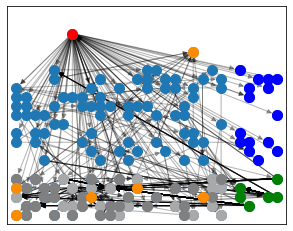

In [86]:
draw_laundry_graph(phishing_gang_sets3[-5],laundry_groups[-5])

### Load Result

In [88]:
gang_patterns=list()
for gang in phishing_gang_sets3:
    graph=nx.MultiDiGraph()
    graph=nx.union(graph,G2.subgraph(gang))
    gang_patterns.append(graph)
laundry_patterns=list()
for group in laundry_groups:
    graph=nx.MultiDiGraph()
    graph=nx.union(graph,G2.subgraph(group))
    laundry_patterns.append(graph)

In [73]:
type(gang_patterns[0])

networkx.classes.multidigraph.MultiDiGraph

In [70]:
#var=['tainted_scores1', 'tainted_scores2', 'phishing_gang_sets', 'laundry_group_sets','suspect_nodes', 'gang_patterns','laundry_patterns']
result_data=dict()
result_data['tainted_scores1']=in_tainted_values1
result_data['tainted_scores2']=in_tainted_values
result_data['phishing_gang_sets']=phishing_gang_sets3
result_data['laundry_group_sets']=laundry_groups
result_data['suspect_nodes']=accum_address

In [89]:
result_data['gang_patterns']=gang_patterns
result_data['laundry_patterns']=laundry_patterns

In [90]:
def write_pickle(data,fname):
    with open(fname, 'wb') as f:
        pickle.dump(data,f)
write_pickle(result_data,'result/subgraph1-result.pkl')

### Phishing Gang Evalution Metrics

In [82]:
import datetime

def add_date(date_str,add_count=1):
    date_list = time.strptime(date_str, "%Y--%m--%d")
    y, m, d = date_list[:3]
    delta = datetime.timedelta(days=add_count)
    date_result = datetime.datetime(y, m, d) + delta
    date_result = date_result.strftime("%Y--%m--%d")
#     print(date_result)
    return date_result 
print(add_date('2018--12--18',3))

2018--12--21


In [83]:
def time_date_distribution(mintim,maxtim):
    time_list=[]
    tim=mintim
    while tim<=maxtim:
        time_list.append(tim)
        date=tim[:12]
        ndate=add_date(date,1)
        tim=time.strftime(ndate+tim[12:])
#         print(tim)
    time_distribution=[(time_list[i],time_list[i+1]) for i in range(len(time_list)-1)]
    return time_distribution.copy()
# print(time_date_distribution(minTime,maxTime))
def transaction_frequncy_ofgroup(time_distribution,group):
    graph=G2.subgraph(group)
    tranfreq_distribution={key:0 for key in time_distribution}
    for idx,edge in enumerate(graph.edges.data()):
        (u,v,eg)=edge
        # gets timestamp of the directed edge
        tim = shift_time(eg['timestamp'])
        for mintim,maxtim in time_distribution:
            if tim>=mintim and tim<maxtim:
                tranfreq_distribution[(mintim,maxtim)]+=1
                break
    return tranfreq_distribution.copy()

In [84]:
G2_time_distribution=time_date_distribution(minTime,maxTime)
gang_tranfreq_distribution=transaction_frequncy_ofgroup(G2_time_distribution,phishing_gang1)
gang_tranfreq_values=list(gang_tranfreq_distribution.values())
print(gang_tranfreq_values)

[24, 68, 52, 136, 190, 42, 40, 24, 77, 125, 74, 57, 98, 37, 37, 27, 28, 30, 32, 71, 45, 31, 45, 64, 40, 53, 24, 51, 37, 28, 25]


In [85]:
control_groups_tranfreq=[]
for group in control_groups4:
    group_tranfreq_distribution=transaction_frequncy_ofgroup(G2_time_distribution,group)
    group_tranfreq_values=list(group_tranfreq_distribution.values())
#     print(len(group_tranfreq_values))
    control_groups_tranfreq.append(group_tranfreq_values)

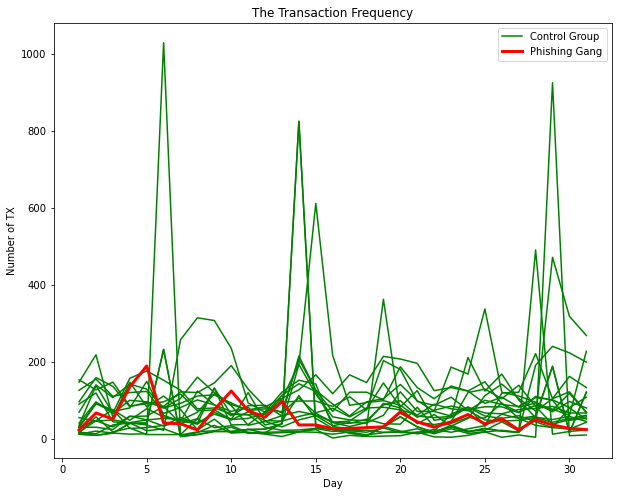

In [86]:
#plot
figsize=(10,8)
plt.figure(figsize=figsize)
plt.xlabel('Day')
plt.ylabel('Number of TX')
plt.title('The Transaction Frequency')
plt.plot(range(1,len(group_tranfreq_values)+1),control_groups_tranfreq[0],color='green',label='Control Group')
for i in range(1,len(control_groups_tranfreq)):
    plt.plot(range(1,len(group_tranfreq_values)+1),control_groups_tranfreq[i],color='green')
plt.plot(range(1,len(gang_tranfreq_values)+1),gang_tranfreq_values,color='red',linewidth=3.0,label='Phishing Gang')
plt.legend(loc='upper right')
plt.show()

In [87]:
def service_reaching_ofgroup(group):
    service_address_nums=0
    for nd in group:
        for snd in G2.succ[nd]:
            if G2.nodes[snd]['iss']==1:
                service_address_nums+=1
    return service_address_nums

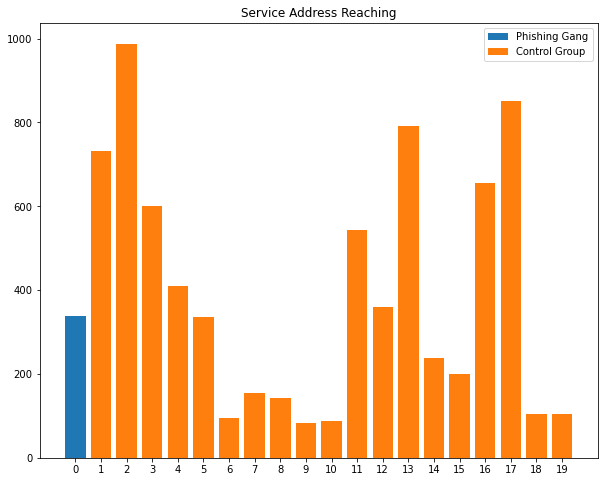

In [88]:
gang_service_reaching=service_reaching_ofgroup(phishing_gang1)
control_groups_service_reaching=[]
for group in control_groups4:
    control_groups_service_reaching.append(service_reaching_ofgroup(group))
#bar
figsize=(10,8)
plt.figure(figsize=figsize)
plt.bar([0],[gang_service_reaching],label='Phishing Gang')
plt.bar(range(1,len(control_groups_service_reaching)+1),control_groups_service_reaching,label='Control Group')
plt.xticks(range(len(control_groups_service_reaching)+1),range(len(control_groups_service_reaching)+1))
plt.legend()
plt.title('Service Address Reaching')
plt.show()

In [89]:
def service_reaching_ratio_ofgroup(group):
    service_address_nums=0
    all_address_nums=0
    for nd in group:
        for snd in G2.succ[nd]:
            if G2.nodes[snd]['iss']==1:
                service_address_nums+=1
            all_address_nums+=1
    return service_address_nums/all_address_nums

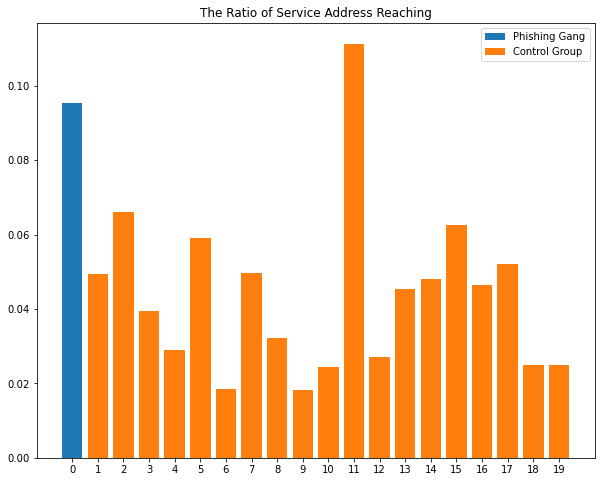

In [90]:
gang_service_reaching_ratio=service_reaching_ratio_ofgroup(phishing_gang1)
control_groups_service_reaching_ratio=[]
for group in control_groups4:
    control_groups_service_reaching_ratio.append(service_reaching_ratio_ofgroup(group))
#bar
figsize=(10,8)
plt.figure(figsize=figsize)
plt.bar([0],[gang_service_reaching_ratio],label='Phishing Gang')
plt.bar(range(1,len(control_groups_service_reaching_ratio)+1),control_groups_service_reaching_ratio,label='Control Group')
plt.xticks(range(len(control_groups_service_reaching_ratio)+1),range(len(control_groups_service_reaching_ratio)+1))
plt.legend()
plt.title('The Ratio of Service Address Reaching')
plt.show()

In [91]:
def toservice_money_ofgroup(group):
    toservice_money=0
    for nd in group:
        for snd,label in G2.succ[nd].items():
            if G2.nodes[snd]['iss']==1:
                toservice_money+=sum([x['amount'] for x in label.values()])
    return toservice_money

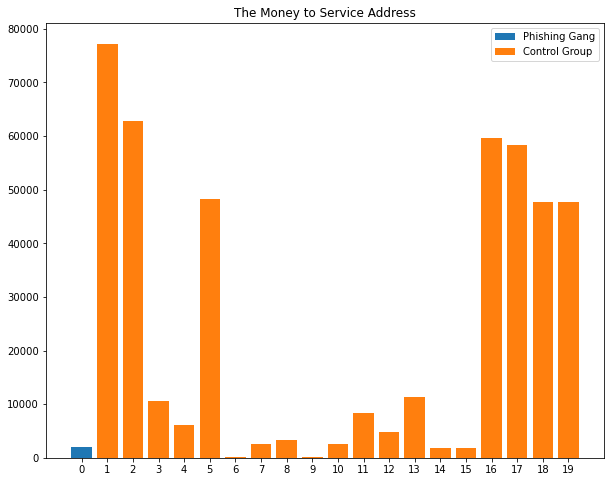

In [92]:
gang_toservice_money=toservice_money_ofgroup(phishing_gang1)
control_groups_toservice_money=[]
for group in control_groups4:
    control_groups_toservice_money.append(toservice_money_ofgroup(group))
#bar
figsize=(10,8)
plt.figure(figsize=figsize)
plt.bar([0],[gang_toservice_money],label='Phishing Gang')
plt.bar(range(1,len(control_groups_toservice_money)+1),control_groups_toservice_money,label='Control Group')
plt.xticks(range(len(control_groups_toservice_money)+1),range(len(control_groups_toservice_money)+1))
plt.legend()
plt.title('The Money to Service Address')
plt.show()

In [93]:
def toservice_money_perday(time_distribution,group):
    graph=G2.subgraph(group)
    toservice_money_distribution={key:0 for key in time_distribution}
    for nd in group:
        for snd,label in G2.succ[nd].items():
            if G2.nodes[snd]['iss']==1:
                for eg in label.values():
                    tim = shift_time(eg['timestamp'])
                    for mintim,maxtim in time_distribution:
                        if tim>=mintim and tim<maxtim:
                            toservice_money_distribution[(mintim,maxtim)]+=eg['amount']
                            break
    return toservice_money_distribution.copy()

In [94]:
gang_toservice_money_distribution=toservice_money_perday(G2_time_distribution,phishing_gang1)
gang_toservice_money_values=list(gang_toservice_money_distribution.values())
print(gang_toservice_money_values)
control_groups_toservice_money=[]
for group in control_groups4:
    group_toservice_money_distribution=toservice_money_perday(G2_time_distribution,group)
    group_toservice_money_values=list(group_toservice_money_distribution.values())
#     print(len(group_tranfreq_values))
    control_groups_toservice_money.append(group_toservice_money_values)

[4.06654518, 243.72231532, 5.18570791, 0.59916, 0.96325212, 7.401744992098485, 258.39412689, 1.95219057, 1.0326249500000002, 9.7839816, 155.67694576622426, 229.97861303000005, 534.6601677499998, 5.23000833, 7.83573387, 2.9568520449974067, 0.0, 0.508, 21.314395230000002, 1.809276537515413, 14.877762910000003, 0.9221890699999999, 31.12025781, 14.42519906, 3.348660273702533, 23.50444466, 6.664315137000001, 21.153943757800544, 75.03908305, 232.00655564500002, 7.283046370000001]


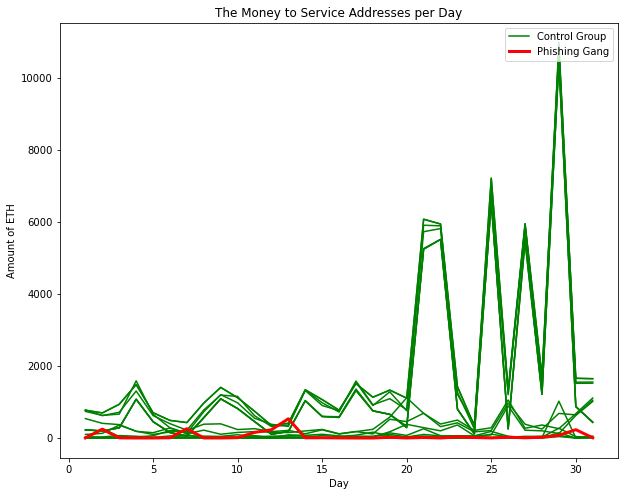

In [95]:
#plot
figsize=(10,8)
plt.figure(figsize=figsize)
plt.xlabel('Day')
plt.ylabel('Amount of ETH')
plt.title('The Money to Service Addresses per Day')
plt.plot(range(1,len(group_toservice_money_values)+1),control_groups_toservice_money[1],color='green',label='Control Group')
for i in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:
    plt.plot(range(1,len(group_toservice_money_values)+1),control_groups_toservice_money[i],color='green')
plt.plot(range(1,len(gang_toservice_money_values)+1),gang_toservice_money_values,color='red',linewidth=3.0,label='Phishing Gang')
plt.legend(loc='upper right')
plt.show()

In [96]:
for idx,nd in enumerate(G.nodes):
    G.nodes[nd]['born_time']=time.strftime("2019--1--20 00:00:00")
for idx,edge in enumerate(G.edges.data()):
    (u,v,eg)=edge
    # gets timestamp of the directed edge
    tim = shift_time(eg['timestamp']) 
    if tim<G.nodes[u]['born_time']:
        G.nodes[u]['born_time']=tim
    if tim<G.nodes[v]['born_time']:
        G.nodes[v]['born_time']=tim

In [97]:
def fresh_address_ofgroup(group,mintim):
    fresh_address_nums=0
    for nd in group:
        if G.nodes[nd]['born_time']>mintim:
            fresh_address_nums+=1
    return fresh_address_nums

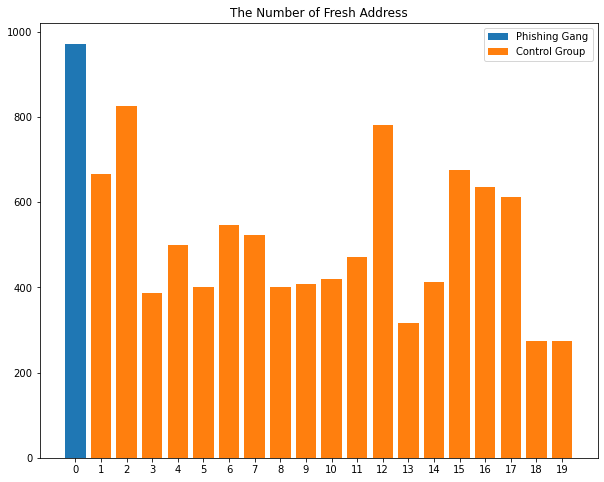

In [98]:
gang_fresh_address= fresh_address_ofgroup(phishing_gang1,minTime)
control_groups_fresh_address=[]
for group in control_groups4:
    control_groups_fresh_address.append( fresh_address_ofgroup(group,minTime))
#bar
figsize=(10,8)
plt.figure(figsize=figsize)
plt.bar([0],[gang_fresh_address],label='Phishing Gang')
plt.bar(range(1,len(control_groups_fresh_address)+1),control_groups_fresh_address,label='Control Group')
plt.xticks(range(len(control_groups_fresh_address)+1),range(len(control_groups_fresh_address)+1))
plt.legend()
plt.title('The Number of Fresh Address')
plt.show()

In [99]:
def interaction_friend_ofgroup(group):
    graph=G2.subgraph(group)
    initial_gang(graph)
    interaction_friend_list=[]
    for nd in group:
        graph.nodes[nd]['visited']=True
        for snd in graph.succ[nd]:
            if nd in graph.succ[snd] and not graph.nodes[snd]['visited']:
                friend=set([nd,snd])
                nd_to_snd=sum([x['amount'] for x in graph[nd][snd].values()])
                snd_to_nd=sum([x['amount'] for x in graph[snd][nd].values()])
                if nd_to_snd>0 and snd_to_nd>0:
                    interaction_friend_list.append(set([nd,snd]))
    return len(interaction_friend_list)

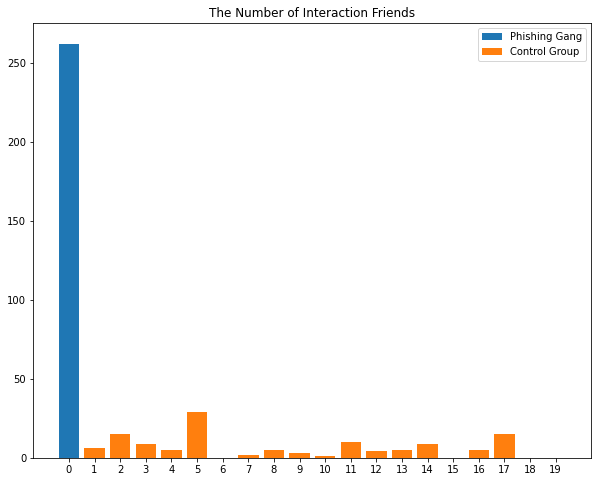

In [100]:
gang_interaction_friend= interaction_friend_ofgroup(phishing_gang1)
control_groups_interaction_friend=[]
for group in control_groups4:
    control_groups_interaction_friend.append(interaction_friend_ofgroup(group))
#bar
figsize=(10,8)
plt.figure(figsize=figsize)
plt.bar([0],[gang_interaction_friend],label='Phishing Gang')
plt.bar(range(1,len(control_groups_interaction_friend)+1),control_groups_interaction_friend,label='Control Group')
plt.xticks(range(len(control_groups_interaction_friend)+1),range(len(control_groups_interaction_friend)+1))
plt.legend()
plt.title('The Number of Interaction Friends')
plt.show()

In [101]:
def capital_return_ratio_ofgroup(group):
    graph=G2.subgraph(group)
    for nd in group:
        if graph.out_degree[nd]>0:
            out_money=0
            return_money=0
            for snd,label in graph.succ[nd].items():
                out_money+=sum([x['amount'] for x in label.values()])
                if nd in graph.succ[snd]:
                    return_money+=sum([x['amount'] for x in graph[snd][nd].values()])
            if out_money<1:
                graph.nodes[nd]['capital_return']=-1
            else:
                graph.nodes[nd]['capital_return']=return_money/(return_money+out_money)
        else:
            graph.nodes[nd]['capital_return']=-1
    return np.mean([graph.nodes[nd]['capital_return'] for nd in group if graph.nodes[nd]['capital_return']!=-1])

0.009786928254423934 [0.012775006912516207, 0.023804796189558393, 0.015040997414599718, 0.07240876470561798, 0.00856900189224893, 0.0, 0.020003361267245136, 0.0, 0.17933211104967897, 0.0, 0.02065274182111006, 0.011036271634073141, 0.019197738121187937, 0.0, 0.0, 0.0396035805974537, 0.04920129872046368, 0.0, 0.0]


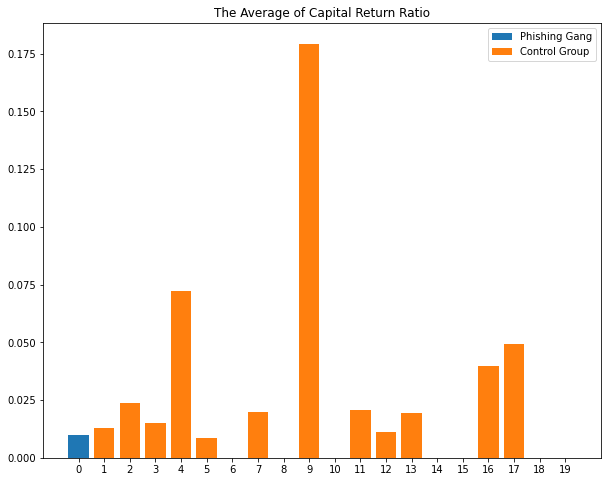

In [102]:
gang_capital_return_ratio= capital_return_ratio_ofgroup(phishing_gang1)
control_groups_capital_return_ratio=[]
for group in control_groups4:
    control_groups_capital_return_ratio.append(capital_return_ratio_ofgroup(group))
print(gang_capital_return_ratio,control_groups_capital_return_ratio)
# bar
figsize=(10,8)
plt.figure(figsize=figsize)
plt.bar([0],[gang_capital_return_ratio],label='Phishing Gang')
plt.bar(range(1,len(control_groups_capital_return_ratio)+1),control_groups_capital_return_ratio,label='Control Group')
plt.xticks(range(len(control_groups_capital_return_ratio)+1),range(len(control_groups_capital_return_ratio)+1))
plt.legend()
plt.title('The Average of Capital Return Ratio')
plt.show()

In [103]:
def net_expend_ofgroup(group):
    graph=G2.subgraph(group)
    net_expend=0
    for nd in group:
        if graph.out_degree[nd]>0:
            out_money=0
            in_money=0
            for snd,label in graph.succ[nd].items():
                out_money+=sum([x['amount'] for x in label.values()])
            for pnd,label in graph.pred[nd].items():
                in_money+=sum([x['amount'] for x in label.values()])
            net_expend+=(out_money-in_money)
    return net_expend

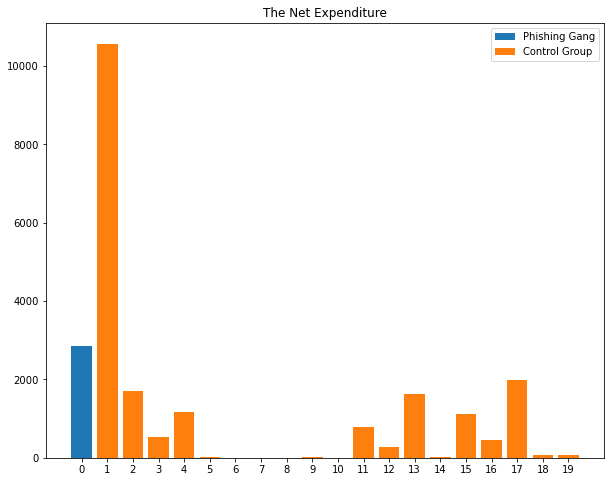

In [104]:
gang_net_expend= net_expend_ofgroup(phishing_gang1)
control_groups_net_expend=[]
for group in control_groups4:
    control_groups_net_expend.append(net_expend_ofgroup(group))
# print(gang_net_expend,control_groups_net_expend)
#bar
figsize=(10,8)
plt.figure(figsize=figsize)
plt.bar([0],[gang_net_expend],label='Phishing Gang')
plt.bar(range(1,len(control_groups_net_expend)+1),control_groups_net_expend,label='Control Group')
plt.xticks(range(len(control_groups_net_expend)+1),range(len(control_groups_net_expend)+1))
plt.legend()
plt.title('The Net Expenditure')
plt.show()

In [123]:
def edge_nodes_ofgroup(group):
    graph=G2.subgraph(group)
    edge_nodes_money=0
    for nd in group:
        if graph.out_degree[nd]==0:
            for snd,label in graph.pred[nd].items():
                edge_nodes_money+=sum([x['amount'] for x in label.values()])
    return edge_nodes_money

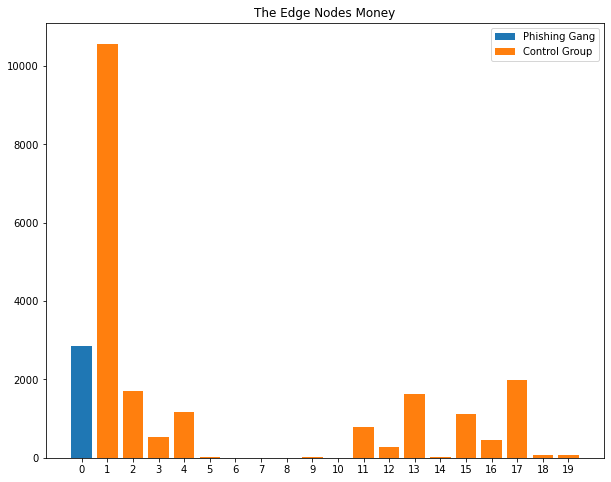

In [124]:
gang_edge_nodes= edge_nodes_ofgroup(phishing_gang1)
control_groups_edge_nodes=[]
for group in control_groups4:
    control_groups_edge_nodes.append(edge_nodes_ofgroup(group))
# print(gang_net_expend,control_groups_net_expend)
#bar
figsize=(10,8)
plt.figure(figsize=figsize)
plt.bar([0],[gang_edge_nodes],label='Phishing Gang')
plt.bar(range(1,len(control_groups_edge_nodes)+1),control_groups_edge_nodes,label='Control Group')
plt.xticks(range(len(control_groups_edge_nodes)+1),range(len(control_groups_edge_nodes)+1))
plt.legend()
plt.title('The Edge Nodes Money')
plt.show()

In [105]:
def balance_change_ofgroup(time_distribution,group):
    balance_change_distribution={key:0 for key in time_distribution}
    for nd in group:
        for snd,label in G2.succ[nd].items():
            if snd not in group:
                for eg in label.values():
                    tim = shift_time(eg['timestamp'])
                    for mintim,maxtim in time_distribution:
                        if tim>=mintim and tim<maxtim:
                            balance_change_distribution[(mintim,maxtim)]-=eg['amount']
                            break
        for pnd,label in G2.pred[nd].items():
            if pnd not in group:
                for eg in label.values():
                    tim = shift_time(eg['timestamp'])
                    for mintim,maxtim in time_distribution:
                        if tim>=mintim and tim<maxtim:
                            balance_change_distribution[(mintim,maxtim)]+=eg['amount']
                            break
    return balance_change_distribution.copy()

In [106]:
gang_balance_change_distribution=balance_change_ofgroup(G2_time_distribution,phishing_gang1)
gang_balance_change_values=[0]+list(gang_balance_change_distribution.values())
gang_balance_values=[sum(gang_balance_change_values[0:i]) for i in range(1,len(gang_balance_change_values)+1)]
# print(gang_toservice_money_values)
control_groups_balance=[]
for group in control_groups4:
    group_balance_change_distribution=balance_change_ofgroup(G2_time_distribution,group)
    group_balance_change_values=[0]+list(group_balance_change_distribution.values())
    group_balance_values=[sum(group_balance_change_values[0:i]) for i in range(1,len(group_balance_change_values)+1)]
#     print(len(group_tranfreq_values))
    control_groups_balance.append(group_balance_values)

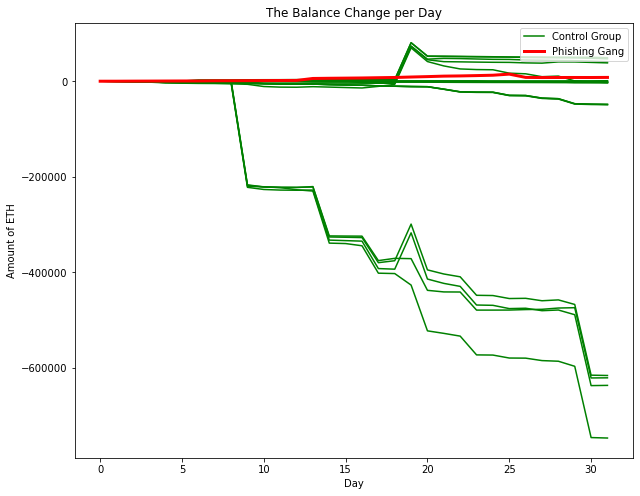

In [112]:
#plot
figsize=(10,8)
plt.figure(figsize=figsize)
plt.xlabel('Day')
plt.ylabel('Amount of ETH')
plt.title('The Balance Change per Day')
plt.plot(range(0,len(group_balance_values)),control_groups_balance[0],color='green',label='Control Group')
for i in range(1,len(control_groups_balance)):
    plt.plot(range(0,len(group_balance_values)),control_groups_balance[i],color='green')
plt.plot(range(0,len(gang_balance_values)),gang_balance_values,color='red',linewidth=3.0,label='Phishing Gang')
plt.legend(loc='upper right')
plt.show()

In [108]:
def average_clustering_ofgroup(group):
    graph=G2.subgraph(group)
    sintigraph=nx.Graph()
    for idx,edge in enumerate(graph.edges.data()):
        u,v,eg=edge
        if sintigraph.has_edge(u,v):
            sintigraph[u][v]['weight']+=eg['amount']
        else:
            sintigraph.add_edge(u,v,weight=eg['amount'])
    return nx.average_clustering(sintigraph)

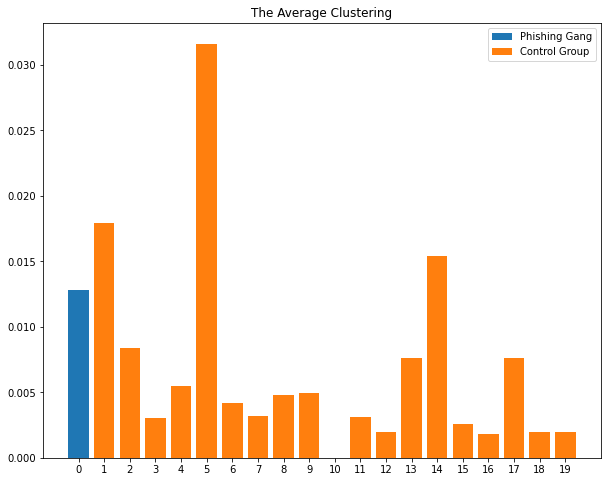

In [109]:
gang_average_clustering= average_clustering_ofgroup(phishing_gang1)
control_groups_average_clustering=[]
for group in control_groups4:
    control_groups_average_clustering.append(average_clustering_ofgroup(group))
# print(gang_average_clustering,control_groups_average_clustering)
#bar
figsize=(10,8)
plt.figure(figsize=figsize)
plt.bar([0],[gang_average_clustering],label='Phishing Gang')
plt.bar(range(1,len(control_groups_average_clustering)+1),control_groups_average_clustering,label='Control Group')
plt.xticks(range(len(control_groups_average_clustering)+1),range(len(control_groups_average_clustering)+1))
plt.legend()
plt.title('The Average Clustering')
plt.show()

In [110]:
def max_degree_centrality_ofgroup(group):
    graph=G2.subgraph(group)
    degree_centrality=nx.degree_centrality(graph)
    return max(list(degree_centrality.values()))

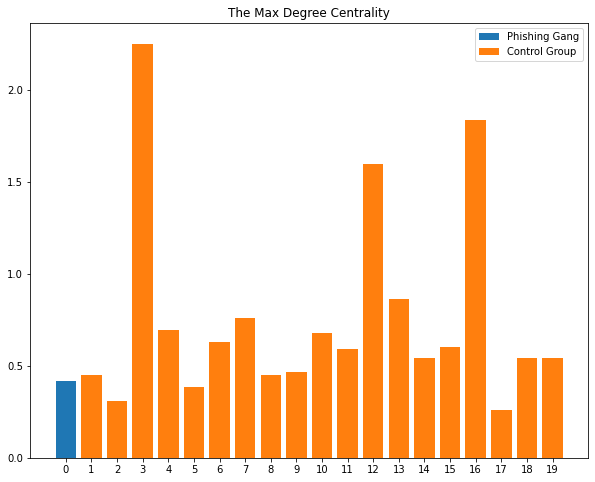

In [111]:
gang_max_degree_centrality= max_degree_centrality_ofgroup(phishing_gang1)
control_groups_max_degree_centrality=[]
for group in control_groups4:
    control_groups_max_degree_centrality.append(max_degree_centrality_ofgroup(group))
# print(gang_max_degree_centrality,control_groups_max_degree_centrality)
#bar
figsize=(10,8)
plt.figure(figsize=figsize)
plt.bar([0],[gang_max_degree_centrality],label='Phishing Gang')
plt.bar(range(1,len(control_groups_max_degree_centrality)+1),control_groups_max_degree_centrality,label='Control Group')
plt.xticks(range(len(control_groups_max_degree_centrality)+1),range(len(control_groups_max_degree_centrality)+1))
plt.legend()
plt.title('The Max Degree Centrality')
plt.show()

In [115]:
def degree_assortativity_ofgroup(group):
    graph=G2.subgraph(group)
    degree_assortativity=nx.degree_assortativity_coefficient(graph)
    return degree_assortativity

In [116]:
gang_degree_assortativity= degree_assortativity_ofgroup(phishing_gang1)
control_groups_degree_assortativity=[]
for group in control_groups4:
    control_groups_degree_assortativity.append(degree_assortativity_ofgroup(group))
print(gang_degree_assortativity,control_groups_degree_assortativity)

-0.38247554694833064 [-0.5668538396433352, -0.2231834952075265, 0.23891388528501942, -0.34939247062866724, 0.42711437436515254, 0.026721526079926054, -0.37229361676176015, -0.2501535370394428, 0.048371600529811126, -0.3569972564236459, -0.44016156300827086, -0.41636831110324773, 0.7631329413325292, 0.31701533162054124, -0.577688316560831, -0.1879282441244208, -0.2936121560628808, -0.5305005922221852, -0.5305005922221852]


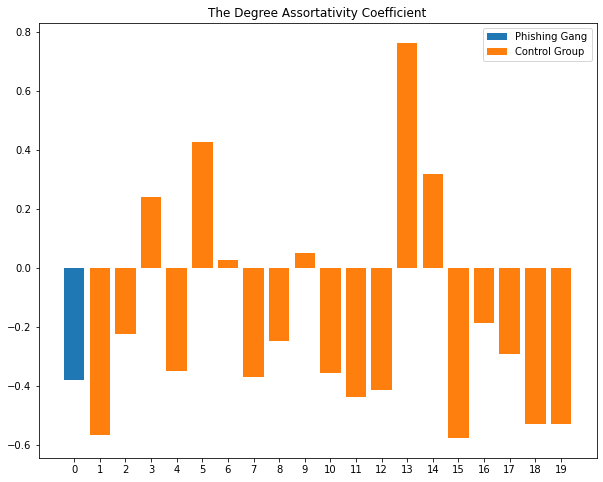

In [118]:
#bar
figsize=(10,8)
plt.figure(figsize=figsize)
plt.bar([0],[gang_degree_assortativity],label='Phishing Gang')
plt.bar(range(1,len(control_groups_degree_assortativity)+1),control_groups_degree_assortativity,label='Control Group')
plt.xticks(range(len(control_groups_degree_assortativity)+1),range(len(control_groups_degree_assortativity)+1))
plt.legend()
plt.title('The Degree Assortativity Coefficient')
plt.show()